In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [42]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

# interp1, 2 are the parameter values, starting from 0
interp1 = 4 # in reality, param no. interp1+1
interp2 = 5 # in reality, param no. interp2+1
max_loss = 3e-5


n_epochs = 10000
n_epochs_latent=5000
batch_size = 1
LR = 2e-5
Lv1_latent_dim = 64
Lv2_latent_dim = 32
epoch_1 = 300

alpha = 0

In [10]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d_batchnorm' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)

In [11]:
f.shape

(10, 800, 64)

## Scale latent codes from Lv 1.

In [12]:
maximum = np.amax(f)
minimum = np.amin(f)
mean = np.mean(f)
AT = maximum-minimum

f = f-mean
f = f/AT

In [13]:
print(np.max(f))
print(np.min(f))

0.5204904498505617
-0.47950955014943836


# Level 2, TVAE (Temporal VAE)

In [14]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 800, 64)

In [15]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]

In [16]:
Lv2_input_shape = Lv2_input.shape[1:]

In [17]:
print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 800, 64)
(800, 64)


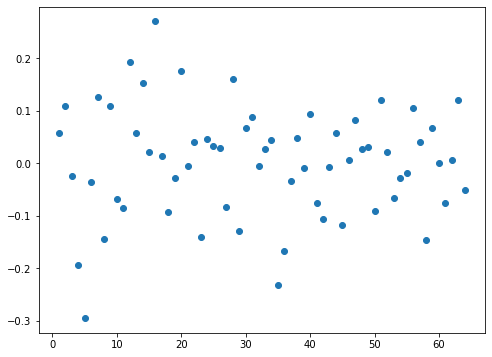

In [18]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
plt.scatter(x_axis1, Lv2_input[0,0,:])

# Encoder

In [19]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 64)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 64)      20544       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 64)      0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

# Decoder

In [20]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

32
800


In [21]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
       
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 25600)        844800      input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 25600)        0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 800, 32)      0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

# loss computation

In [22]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [24]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_Lv2/decoder_%d_batchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_Lv2/encoder_%d_batchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [25]:
Lv2_input.shape
print(type(Lv2_input))

<class 'numpy.ndarray'>


# Warm up

In [26]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/10000
10/10 [==============================] - 6s 10ms/step - loss: -138.0935
Epoch 2/10000
10/10 [==============================] - 0s 9ms/step - loss: -138.4638
Epoch 3/10000
10/10 [==============================] - 0s 10ms/step - loss: -139.8342
Epoch 4/10000
10/10 [==============================] - 0s 8ms/step - loss: -143.2934
Epoch 5/10000
10/10 [==============================] - 0s 10ms/step - loss: -148.5497
Epoch 6/10000
10/10 [==============================] - 0s 10ms/step - loss: -154.7942
Epoch 7/10000
10/10 [==============================] - 0s 11ms/step - loss: -160.8039
Epoch 8/10000
10/10 [==============================] - 0s 9ms/step - loss: -166.6209
Epoch 9/10000
10/10 [==============================] - 0s 8ms/step - loss: -170.9777
Epoch 10/10000
10/10 [==============================] - 0s 11ms/step - loss: -175.9246
Epoch 11/10000
10/10 [==============================] - 0s 11ms/step - loss: -180.4471
Epoch 12/10000
10/10 [==============================] - 

10/10 [==============================] - 0s 9ms/step - loss: -397.9608
Epoch 96/10000
10/10 [==============================] - 0s 10ms/step - loss: -398.7230
Epoch 97/10000
10/10 [==============================] - ETA: 0s - loss: -402.63 - 0s 10ms/step - loss: -401.6675
Epoch 98/10000
10/10 [==============================] - 0s 8ms/step - loss: -402.9788
Epoch 99/10000
10/10 [==============================] - 0s 10ms/step - loss: -404.7401
Epoch 100/10000
10/10 [==============================] - 0s 10ms/step - loss: -406.2189
Epoch 101/10000
10/10 [==============================] - 0s 9ms/step - loss: -408.8317
Epoch 102/10000
10/10 [==============================] - 0s 10ms/step - loss: -411.7336
Epoch 103/10000
10/10 [==============================] - 0s 9ms/step - loss: -411.7864
Epoch 104/10000
10/10 [==============================] - 0s 10ms/step - loss: -412.6686
Epoch 105/10000
10/10 [==============================] - 0s 10ms/step - loss: -413.7140
Epoch 106/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -545.8866
Epoch 189/10000
10/10 [==============================] - 0s 10ms/step - loss: -543.9009
Epoch 190/10000
10/10 [==============================] - 0s 10ms/step - loss: -548.7091
Epoch 191/10000
10/10 [==============================] - 0s 10ms/step - loss: -551.7085
Epoch 192/10000
10/10 [==============================] - 0s 10ms/step - loss: -551.0864
Epoch 193/10000
10/10 [==============================] - 0s 11ms/step - loss: -553.4538
Epoch 194/10000
10/10 [==============================] - 0s 10ms/step - loss: -555.0567
Epoch 195/10000
10/10 [==============================] - 0s 12ms/step - loss: -557.3237
Epoch 196/10000
10/10 [==============================] - 0s 11ms/step - loss: -557.3271
Epoch 197/10000
10/10 [==============================] - 0s 9ms/step - loss: -558.0279
Epoch 198/10000
10/10 [==============================] - 0s 10ms/step - loss: -560.6314
Epoch 199/10000
10/10 [===========================

10/10 [==============================] - 0s 9ms/step - loss: -672.2712
Epoch 282/10000
10/10 [==============================] - 0s 9ms/step - loss: -674.2263
Epoch 283/10000
10/10 [==============================] - 0s 9ms/step - loss: -675.5064
Epoch 284/10000
10/10 [==============================] - 0s 11ms/step - loss: -676.9189
Epoch 285/10000
10/10 [==============================] - 0s 11ms/step - loss: -679.1710
Epoch 286/10000
10/10 [==============================] - 0s 12ms/step - loss: -678.2583
Epoch 287/10000
10/10 [==============================] - 0s 12ms/step - loss: -679.5313
Epoch 288/10000
10/10 [==============================] - 0s 11ms/step - loss: -682.6773
Epoch 289/10000
10/10 [==============================] - 0s 9ms/step - loss: -681.4142
Epoch 290/10000
10/10 [==============================] - 0s 10ms/step - loss: -685.2002
Epoch 291/10000
10/10 [==============================] - 0s 11ms/step - loss: -684.5025
Epoch 292/10000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: -786.5457
Epoch 375/10000
10/10 [==============================] - 0s 10ms/step - loss: -786.6382
Epoch 376/10000
10/10 [==============================] - 0s 10ms/step - loss: -792.7062
Epoch 377/10000
10/10 [==============================] - 0s 9ms/step - loss: -790.9655
Epoch 378/10000
10/10 [==============================] - 0s 11ms/step - loss: -792.7967
Epoch 379/10000
10/10 [==============================] - 0s 11ms/step - loss: -792.2611
Epoch 380/10000
10/10 [==============================] - 0s 9ms/step - loss: -796.5409
Epoch 381/10000
10/10 [==============================] - 0s 8ms/step - loss: -794.4771
Epoch 382/10000
10/10 [==============================] - 0s 9ms/step - loss: -794.8928
Epoch 383/10000
10/10 [==============================] - 0s 10ms/step - loss: -796.6091
Epoch 384/10000
10/10 [==============================] - 0s 9ms/step - loss: -803.6907
Epoch 385/10000
10/10 [==============================]

10/10 [==============================] - 0s 10ms/step - loss: -900.5630
Epoch 468/10000
10/10 [==============================] - 0s 10ms/step - loss: -895.7916
Epoch 469/10000
10/10 [==============================] - 0s 9ms/step - loss: -902.6233
Epoch 470/10000
10/10 [==============================] - 0s 9ms/step - loss: -906.9678
Epoch 471/10000
10/10 [==============================] - 0s 10ms/step - loss: -904.9543
Epoch 472/10000
10/10 [==============================] - 0s 8ms/step - loss: -905.9409
Epoch 473/10000
10/10 [==============================] - 0s 8ms/step - loss: -900.3065
Epoch 474/10000
10/10 [==============================] - 0s 11ms/step - loss: -911.2651
Epoch 475/10000
10/10 [==============================] - 0s 9ms/step - loss: -906.8112
Epoch 476/10000
10/10 [==============================] - 0s 11ms/step - loss: -912.7717
Epoch 477/10000
10/10 [==============================] - 0s 11ms/step - loss: -910.8212
Epoch 478/10000
10/10 [==============================

10/10 [==============================] - 0s 9ms/step - loss: -997.7132
Epoch 561/10000
10/10 [==============================] - 0s 10ms/step - loss: -1002.3326
Epoch 562/10000
10/10 [==============================] - 0s 10ms/step - loss: -1009.2098
Epoch 563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1011.1803
Epoch 564/10000
10/10 [==============================] - 0s 10ms/step - loss: -1012.6832
Epoch 565/10000
10/10 [==============================] - 0s 10ms/step - loss: -1013.4474
Epoch 566/10000
10/10 [==============================] - 0s 10ms/step - loss: -1011.8801
Epoch 567/10000
10/10 [==============================] - 0s 10ms/step - loss: -1013.7014
Epoch 568/10000
10/10 [==============================] - 0s 11ms/step - loss: -1014.9667
Epoch 569/10000
10/10 [==============================] - 0s 8ms/step - loss: -1015.6390
Epoch 570/10000
10/10 [==============================] - 0s 10ms/step - loss: -1019.8585
Epoch 571/10000
10/10 [=================

10/10 [==============================] - 0s 9ms/step - loss: -1109.0754
Epoch 653/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.9933
Epoch 654/10000
10/10 [==============================] - 0s 11ms/step - loss: -1110.0913
Epoch 655/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.8427
Epoch 656/10000
10/10 [==============================] - 0s 9ms/step - loss: -1113.4170
Epoch 657/10000
10/10 [==============================] - 0s 11ms/step - loss: -1111.1985
Epoch 658/10000
10/10 [==============================] - 0s 9ms/step - loss: -1112.0539
Epoch 659/10000
10/10 [==============================] - 0s 11ms/step - loss: -1112.9799
Epoch 660/10000
10/10 [==============================] - 0s 8ms/step - loss: -1116.7658
Epoch 661/10000
10/10 [==============================] - 0s 10ms/step - loss: -1116.9364
Epoch 662/10000
10/10 [==============================] - 0s 10ms/step - loss: -1116.6846
Epoch 663/10000
10/10 [====================

10/10 [==============================] - 0s 10ms/step - loss: -1198.2550
Epoch 745/10000
10/10 [==============================] - 0s 13ms/step - loss: -1199.1640
Epoch 746/10000
10/10 [==============================] - 0s 12ms/step - loss: -1206.9701
Epoch 747/10000
10/10 [==============================] - 0s 10ms/step - loss: -1201.7460
Epoch 748/10000
10/10 [==============================] - 0s 9ms/step - loss: -1207.5715
Epoch 749/10000
10/10 [==============================] - 0s 11ms/step - loss: -1209.0270
Epoch 750/10000
10/10 [==============================] - 0s 9ms/step - loss: -1211.5570
Epoch 751/10000
10/10 [==============================] - 0s 11ms/step - loss: -1212.9430
Epoch 752/10000
10/10 [==============================] - 0s 10ms/step - loss: -1211.2984
Epoch 753/10000
10/10 [==============================] - 0s 11ms/step - loss: -1201.4771
Epoch 754/10000
10/10 [==============================] - 0s 10ms/step - loss: -1210.2896
Epoch 755/10000
10/10 [================

10/10 [==============================] - 0s 9ms/step - loss: -1286.3124
Epoch 837/10000
10/10 [==============================] - 0s 11ms/step - loss: -1285.6064
Epoch 838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1279.2122
Epoch 839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1294.1900
Epoch 840/10000
10/10 [==============================] - 0s 11ms/step - loss: -1284.0898
Epoch 841/10000
10/10 [==============================] - 0s 10ms/step - loss: -1291.4029
Epoch 842/10000
10/10 [==============================] - 0s 9ms/step - loss: -1290.6603
Epoch 843/10000
10/10 [==============================] - 0s 10ms/step - loss: -1289.6293
Epoch 844/10000
10/10 [==============================] - 0s 10ms/step - loss: -1296.5161
Epoch 845/10000
10/10 [==============================] - 0s 9ms/step - loss: -1276.3410
Epoch 846/10000
10/10 [==============================] - 0s 9ms/step - loss: -1288.3211
Epoch 847/10000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: -1361.6067
Epoch 929/10000
10/10 [==============================] - 0s 10ms/step - loss: -1361.9449
Epoch 930/10000
10/10 [==============================] - 0s 9ms/step - loss: -1359.7164
Epoch 931/10000
10/10 [==============================] - 0s 9ms/step - loss: -1347.9278
Epoch 932/10000
10/10 [==============================] - 0s 9ms/step - loss: -1362.6094
Epoch 933/10000
10/10 [==============================] - 0s 9ms/step - loss: -1364.5700
Epoch 934/10000
10/10 [==============================] - 0s 11ms/step - loss: -1358.1348
Epoch 935/10000
10/10 [==============================] - 0s 10ms/step - loss: -1365.2279
Epoch 936/10000
10/10 [==============================] - 0s 8ms/step - loss: -1368.2678
Epoch 937/10000
10/10 [==============================] - 0s 9ms/step - loss: -1346.2996
Epoch 938/10000
10/10 [==============================] - 0s 9ms/step - loss: -1364.0157
Epoch 939/10000
10/10 [======================

10/10 [==============================] - 0s 10ms/step - loss: -1407.7897
Epoch 1017/10000
10/10 [==============================] - 0s 8ms/step - loss: -1409.4228
Epoch 1018/10000
10/10 [==============================] - 0s 10ms/step - loss: -1418.7261
Epoch 1019/10000
10/10 [==============================] - 0s 9ms/step - loss: -1408.8389
Epoch 1020/10000
10/10 [==============================] - 0s 10ms/step - loss: -1415.2792
Epoch 1021/10000
10/10 [==============================] - 0s 10ms/step - loss: -1413.7052
Epoch 1022/10000
10/10 [==============================] - 0s 10ms/step - loss: -1408.9711
Epoch 1023/10000
10/10 [==============================] - 0s 9ms/step - loss: -1413.0907
Epoch 1024/10000
10/10 [==============================] - 0s 10ms/step - loss: -1418.5348
Epoch 1025/10000
10/10 [==============================] - 0s 11ms/step - loss: -1405.6209
Epoch 1026/10000
10/10 [==============================] - 0s 8ms/step - loss: -1395.2772
Epoch 1027/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1447.8722
Epoch 1108/10000
10/10 [==============================] - 0s 11ms/step - loss: -1459.5617
Epoch 1109/10000
10/10 [==============================] - 0s 11ms/step - loss: -1454.9481
Epoch 1110/10000
10/10 [==============================] - 0s 10ms/step - loss: -1461.0736
Epoch 1111/10000
10/10 [==============================] - 0s 10ms/step - loss: -1471.1976
Epoch 1112/10000
10/10 [==============================] - 0s 12ms/step - loss: -1471.0376
Epoch 1113/10000
10/10 [==============================] - 0s 10ms/step - loss: -1457.4895
Epoch 1114/10000
10/10 [==============================] - 0s 10ms/step - loss: -1463.7935
Epoch 1115/10000
10/10 [==============================] - 0s 9ms/step - loss: -1475.0616
Epoch 1116/10000
10/10 [==============================] - 0s 9ms/step - loss: -1453.7049
Epoch 1117/10000
10/10 [==============================] - 0s 10ms/step - loss: -1474.5161
Epoch 1118/10000
10/10 [=====

10/10 [==============================] - 0s 10ms/step - loss: -1502.8777
Epoch 1199/10000
10/10 [==============================] - 0s 9ms/step - loss: -1474.5800
Epoch 1200/10000
10/10 [==============================] - 0s 10ms/step - loss: -1511.3529
Epoch 1201/10000
10/10 [==============================] - 0s 8ms/step - loss: -1501.9935
Epoch 1202/10000
10/10 [==============================] - 0s 10ms/step - loss: -1487.6807
Epoch 1203/10000
10/10 [==============================] - 0s 10ms/step - loss: -1512.9301
Epoch 1204/10000
10/10 [==============================] - 0s 8ms/step - loss: -1485.8720
Epoch 1205/10000
10/10 [==============================] - 0s 10ms/step - loss: -1493.5691
Epoch 1206/10000
10/10 [==============================] - 0s 9ms/step - loss: -1500.8577
Epoch 1207/10000
10/10 [==============================] - 0s 9ms/step - loss: -1495.2242
Epoch 1208/10000
10/10 [==============================] - 0s 10ms/step - loss: -1510.4013
Epoch 1209/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1525.9259
Epoch 1290/10000
10/10 [==============================] - 0s 11ms/step - loss: -1534.6940
Epoch 1291/10000
10/10 [==============================] - 0s 9ms/step - loss: -1522.6252
Epoch 1292/10000
10/10 [==============================] - 0s 10ms/step - loss: -1506.4799
Epoch 1293/10000
10/10 [==============================] - 0s 10ms/step - loss: -1509.7211
Epoch 1294/10000
10/10 [==============================] - 0s 10ms/step - loss: -1515.1889
Epoch 1295/10000
10/10 [==============================] - 0s 11ms/step - loss: -1540.0941
Epoch 1296/10000
10/10 [==============================] - 0s 10ms/step - loss: -1540.8205
Epoch 1297/10000
10/10 [==============================] - 0s 8ms/step - loss: -1532.4620
Epoch 1298/10000
10/10 [==============================] - 0s 10ms/step - loss: -1544.0339
Epoch 1299/10000
10/10 [==============================] - 0s 10ms/step - loss: -1525.7078
Epoch 1300/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1557.6077
Epoch 1381/10000
10/10 [==============================] - 0s 8ms/step - loss: -1563.5367
Epoch 1382/10000
10/10 [==============================] - 0s 10ms/step - loss: -1560.3503
Epoch 1383/10000
10/10 [==============================] - 0s 10ms/step - loss: -1572.8150
Epoch 1384/10000
10/10 [==============================] - 0s 9ms/step - loss: -1557.1098
Epoch 1385/10000
10/10 [==============================] - 0s 9ms/step - loss: -1530.6758
Epoch 1386/10000
10/10 [==============================] - 0s 9ms/step - loss: -1558.6666
Epoch 1387/10000
10/10 [==============================] - 0s 10ms/step - loss: -1549.8212
Epoch 1388/10000
10/10 [==============================] - 0s 10ms/step - loss: -1571.3413
Epoch 1389/10000
10/10 [==============================] - 0s 9ms/step - loss: -1532.0143
Epoch 1390/10000
10/10 [==============================] - 0s 9ms/step - loss: -1531.8157
Epoch 1391/10000
10/10 [=========

10/10 [==============================] - 0s 8ms/step - loss: -1572.3997
Epoch 1472/10000
10/10 [==============================] - 0s 10ms/step - loss: -1553.6450
Epoch 1473/10000
10/10 [==============================] - 0s 9ms/step - loss: -1586.0139
Epoch 1474/10000
10/10 [==============================] - 0s 10ms/step - loss: -1591.3686
Epoch 1475/10000
10/10 [==============================] - 0s 10ms/step - loss: -1565.2775
Epoch 1476/10000
10/10 [==============================] - 0s 9ms/step - loss: -1569.5631
Epoch 1477/10000
10/10 [==============================] - 0s 9ms/step - loss: -1557.9176
Epoch 1478/10000
10/10 [==============================] - 0s 9ms/step - loss: -1589.4393
Epoch 1479/10000
10/10 [==============================] - 0s 10ms/step - loss: -1580.7816
Epoch 1480/10000
10/10 [==============================] - 0s 10ms/step - loss: -1592.0744
Epoch 1481/10000
10/10 [==============================] - 0s 10ms/step - loss: -1574.6572
Epoch 1482/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1603.6101
Epoch 1563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1594.8412
Epoch 1564/10000
10/10 [==============================] - 0s 11ms/step - loss: -1608.6004
Epoch 1565/10000
10/10 [==============================] - 0s 10ms/step - loss: -1609.4651
Epoch 1566/10000
10/10 [==============================] - 0s 10ms/step - loss: -1595.5756
Epoch 1567/10000
10/10 [==============================] - 0s 9ms/step - loss: -1596.4311
Epoch 1568/10000
10/10 [==============================] - 0s 9ms/step - loss: -1609.5948
Epoch 1569/10000
10/10 [==============================] - 0s 10ms/step - loss: -1612.6649
Epoch 1570/10000
10/10 [==============================] - 0s 9ms/step - loss: -1593.1422
Epoch 1571/10000
10/10 [==============================] - 0s 9ms/step - loss: -1613.7654
Epoch 1572/10000
10/10 [==============================] - 0s 9ms/step - loss: -1597.7331
Epoch 1573/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1606.9811
Epoch 1654/10000
10/10 [==============================] - 0s 11ms/step - loss: -1609.6746
Epoch 1655/10000
10/10 [==============================] - 0s 10ms/step - loss: -1631.9496
Epoch 1656/10000
10/10 [==============================] - 0s 11ms/step - loss: -1611.1223
Epoch 1657/10000
10/10 [==============================] - 0s 9ms/step - loss: -1624.3741
Epoch 1658/10000
10/10 [==============================] - 0s 10ms/step - loss: -1630.2041
Epoch 1659/10000
10/10 [==============================] - 0s 10ms/step - loss: -1617.4169
Epoch 1660/10000
10/10 [==============================] - 0s 9ms/step - loss: -1618.8936
Epoch 1661/10000
10/10 [==============================] - 0s 9ms/step - loss: -1631.7702
Epoch 1662/10000
10/10 [==============================] - 0s 10ms/step - loss: -1616.2589
Epoch 1663/10000
10/10 [==============================] - 0s 10ms/step - loss: -1615.1149
Epoch 1664/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1633.3576
Epoch 1745/10000
10/10 [==============================] - 0s 10ms/step - loss: -1647.6576
Epoch 1746/10000
10/10 [==============================] - 0s 10ms/step - loss: -1629.8818
Epoch 1747/10000
10/10 [==============================] - 0s 10ms/step - loss: -1633.5061
Epoch 1748/10000
10/10 [==============================] - 0s 10ms/step - loss: -1623.2306
Epoch 1749/10000
10/10 [==============================] - 0s 9ms/step - loss: -1635.4359
Epoch 1750/10000
10/10 [==============================] - 0s 9ms/step - loss: -1647.3712
Epoch 1751/10000
10/10 [==============================] - 0s 9ms/step - loss: -1626.6537
Epoch 1752/10000
10/10 [==============================] - 0s 10ms/step - loss: -1603.0920
Epoch 1753/10000
10/10 [==============================] - 0s 10ms/step - loss: -1649.9144
Epoch 1754/10000
10/10 [==============================] - 0s 10ms/step - loss: -1631.7210
Epoch 1755/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1640.5599
Epoch 1836/10000
10/10 [==============================] - 0s 10ms/step - loss: -1641.2662
Epoch 1837/10000
10/10 [==============================] - 0s 9ms/step - loss: -1660.0717
Epoch 1838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1653.4409
Epoch 1839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1637.4933
Epoch 1840/10000
10/10 [==============================] - 0s 9ms/step - loss: -1642.7634
Epoch 1841/10000
10/10 [==============================] - 0s 9ms/step - loss: -1650.9273
Epoch 1842/10000
10/10 [==============================] - 0s 9ms/step - loss: -1658.1746
Epoch 1843/10000
10/10 [==============================] - 0s 8ms/step - loss: -1650.0510
Epoch 1844/10000
10/10 [==============================] - 0s 10ms/step - loss: -1638.7868
Epoch 1845/10000
10/10 [==============================] - 0s 10ms/step - loss: -1664.4943
Epoch 1846/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1650.8715
Epoch 1927/10000
10/10 [==============================] - 0s 9ms/step - loss: -1651.7289
Epoch 1928/10000
10/10 [==============================] - 0s 11ms/step - loss: -1655.2163
Epoch 1929/10000
10/10 [==============================] - 0s 9ms/step - loss: -1669.8940
Epoch 1930/10000
10/10 [==============================] - 0s 9ms/step - loss: -1644.5925
Epoch 1931/10000
10/10 [==============================] - 0s 9ms/step - loss: -1640.0732
Epoch 1932/10000
10/10 [==============================] - 0s 9ms/step - loss: -1627.8187
Epoch 1933/10000
10/10 [==============================] - 0s 9ms/step - loss: -1648.3190
Epoch 1934/10000
10/10 [==============================] - 0s 11ms/step - loss: -1664.6399
Epoch 1935/10000
10/10 [==============================] - 0s 9ms/step - loss: -1652.0492
Epoch 1936/10000
10/10 [==============================] - 0s 8ms/step - loss: -1653.8027
Epoch 1937/10000
10/10 [============

10/10 [==============================] - 0s 10ms/step - loss: -1676.3839
Epoch 2014/10000
10/10 [==============================] - 0s 10ms/step - loss: -1653.9837
Epoch 2015/10000
10/10 [==============================] - 0s 10ms/step - loss: -1652.8579
Epoch 2016/10000
10/10 [==============================] - 0s 10ms/step - loss: -1656.0446
Epoch 2017/10000
10/10 [==============================] - 0s 10ms/step - loss: -1667.5026
Epoch 2018/10000
10/10 [==============================] - 0s 10ms/step - loss: -1679.6179
Epoch 2019/10000
10/10 [==============================] - 0s 9ms/step - loss: -1651.8896
Epoch 2020/10000
10/10 [==============================] - 0s 9ms/step - loss: -1660.6454
Epoch 2021/10000
10/10 [==============================] - 0s 10ms/step - loss: -1665.4501
Epoch 2022/10000
10/10 [==============================] - 0s 9ms/step - loss: -1634.8756
Epoch 2023/10000
10/10 [==============================] - 0s 9ms/step - loss: -1653.8476
Epoch 2024/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1682.6584
Epoch 2105/10000
10/10 [==============================] - 0s 9ms/step - loss: -1667.1629
Epoch 2106/10000
10/10 [==============================] - 0s 12ms/step - loss: -1667.0363
Epoch 2107/10000
10/10 [==============================] - 0s 11ms/step - loss: -1670.3879
Epoch 2108/10000
10/10 [==============================] - 0s 11ms/step - loss: -1652.7763
Epoch 2109/10000
10/10 [==============================] - 0s 10ms/step - loss: -1692.2922
Epoch 2110/10000
10/10 [==============================] - 0s 10ms/step - loss: -1674.1796
Epoch 2111/10000
10/10 [==============================] - 0s 9ms/step - loss: -1664.7054
Epoch 2112/10000
10/10 [==============================] - 0s 11ms/step - loss: -1642.1087
Epoch 2113/10000
10/10 [==============================] - 0s 10ms/step - loss: -1681.1225
Epoch 2114/10000
10/10 [==============================] - 0s 9ms/step - loss: -1664.2912
Epoch 2115/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1695.3135
Epoch 2196/10000
10/10 [==============================] - 0s 9ms/step - loss: -1670.0349
Epoch 2197/10000
10/10 [==============================] - 0s 11ms/step - loss: -1693.6125
Epoch 2198/10000
10/10 [==============================] - 0s 8ms/step - loss: -1660.9538
Epoch 2199/10000
10/10 [==============================] - 0s 8ms/step - loss: -1673.3345
Epoch 2200/10000
10/10 [==============================] - 0s 9ms/step - loss: -1694.7790
Epoch 2201/10000
10/10 [==============================] - 0s 8ms/step - loss: -1668.2077
Epoch 2202/10000
10/10 [==============================] - 0s 10ms/step - loss: -1695.7737
Epoch 2203/10000
10/10 [==============================] - 0s 11ms/step - loss: -1681.0895
Epoch 2204/10000
10/10 [==============================] - 0s 10ms/step - loss: -1679.3404
Epoch 2205/10000
10/10 [==============================] - 0s 10ms/step - loss: -1686.4471
Epoch 2206/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1656.3629
Epoch 2287/10000
10/10 [==============================] - 0s 10ms/step - loss: -1657.8161
Epoch 2288/10000
10/10 [==============================] - 0s 9ms/step - loss: -1700.4703
Epoch 2289/10000
10/10 [==============================] - 0s 9ms/step - loss: -1683.9224
Epoch 2290/10000
10/10 [==============================] - 0s 11ms/step - loss: -1682.5993
Epoch 2291/10000
10/10 [==============================] - 0s 12ms/step - loss: -1675.6549
Epoch 2292/10000
10/10 [==============================] - 0s 8ms/step - loss: -1687.2766
Epoch 2293/10000
10/10 [==============================] - 0s 10ms/step - loss: -1695.8838
Epoch 2294/10000
10/10 [==============================] - 0s 11ms/step - loss: -1680.1634
Epoch 2295/10000
10/10 [==============================] - 0s 10ms/step - loss: -1678.8618
Epoch 2296/10000
10/10 [==============================] - 0s 10ms/step - loss: -1678.4311
Epoch 2297/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1692.6398
Epoch 2378/10000
10/10 [==============================] - 0s 10ms/step - loss: -1676.8824
Epoch 2379/10000
10/10 [==============================] - 0s 10ms/step - loss: -1695.9154
Epoch 2380/10000
10/10 [==============================] - 0s 10ms/step - loss: -1688.9449
Epoch 2381/10000
10/10 [==============================] - 0s 8ms/step - loss: -1700.3511
Epoch 2382/10000
10/10 [==============================] - 0s 8ms/step - loss: -1690.3669
Epoch 2383/10000
10/10 [==============================] - 0s 10ms/step - loss: -1703.6462
Epoch 2384/10000
10/10 [==============================] - 0s 10ms/step - loss: -1682.4738
Epoch 2385/10000
10/10 [==============================] - 0s 9ms/step - loss: -1693.8573
Epoch 2386/10000
10/10 [==============================] - 0s 10ms/step - loss: -1687.0860
Epoch 2387/10000
10/10 [==============================] - 0s 9ms/step - loss: -1710.3390
Epoch 2388/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1698.4266
Epoch 2469/10000
10/10 [==============================] - 0s 10ms/step - loss: -1698.2286
Epoch 2470/10000
10/10 [==============================] - 0s 10ms/step - loss: -1682.8895
Epoch 2471/10000
10/10 [==============================] - 0s 10ms/step - loss: -1698.0790
Epoch 2472/10000
10/10 [==============================] - 0s 10ms/step - loss: -1716.0867
Epoch 2473/10000
10/10 [==============================] - 0s 9ms/step - loss: -1682.3616
Epoch 2474/10000
10/10 [==============================] - 0s 9ms/step - loss: -1699.0017
Epoch 2475/10000
10/10 [==============================] - 0s 10ms/step - loss: -1690.6357
Epoch 2476/10000
10/10 [==============================] - 0s 10ms/step - loss: -1700.9289
Epoch 2477/10000
10/10 [==============================] - 0s 10ms/step - loss: -1680.9298
Epoch 2478/10000
10/10 [==============================] - 0s 8ms/step - loss: -1692.7406
Epoch 2479/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1696.2422
Epoch 2560/10000
10/10 [==============================] - 0s 10ms/step - loss: -1721.7992
Epoch 2561/10000
10/10 [==============================] - 0s 9ms/step - loss: -1720.5759
Epoch 2562/10000
10/10 [==============================] - 0s 11ms/step - loss: -1674.8576
Epoch 2563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1693.0197
Epoch 2564/10000
10/10 [==============================] - 0s 10ms/step - loss: -1690.2959
Epoch 2565/10000
10/10 [==============================] - 0s 11ms/step - loss: -1696.6258
Epoch 2566/10000
10/10 [==============================] - 0s 9ms/step - loss: -1706.8777
Epoch 2567/10000
10/10 [==============================] - 0s 11ms/step - loss: -1700.4732
Epoch 2568/10000
10/10 [==============================] - 0s 9ms/step - loss: -1725.9735
Epoch 2569/10000
10/10 [==============================] - 0s 12ms/step - loss: -1703.9313
Epoch 2570/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1701.7110
Epoch 2651/10000
10/10 [==============================] - 0s 9ms/step - loss: -1699.8467
Epoch 2652/10000
10/10 [==============================] - 0s 10ms/step - loss: -1705.9719
Epoch 2653/10000
10/10 [==============================] - 0s 9ms/step - loss: -1690.3710
Epoch 2654/10000
10/10 [==============================] - 0s 9ms/step - loss: -1706.8234
Epoch 2655/10000
10/10 [==============================] - 0s 10ms/step - loss: -1703.4071
Epoch 2656/10000
10/10 [==============================] - 0s 11ms/step - loss: -1679.4443
Epoch 2657/10000
10/10 [==============================] - 0s 10ms/step - loss: -1708.5827
Epoch 2658/10000
10/10 [==============================] - 0s 9ms/step - loss: -1725.6251
Epoch 2659/10000
10/10 [==============================] - 0s 9ms/step - loss: -1696.3520
Epoch 2660/10000
10/10 [==============================] - 0s 10ms/step - loss: -1693.8034
Epoch 2661/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1700.5633
Epoch 2742/10000
10/10 [==============================] - 0s 8ms/step - loss: -1731.9074
Epoch 2743/10000
10/10 [==============================] - 0s 9ms/step - loss: -1720.0554
Epoch 2744/10000
10/10 [==============================] - 0s 10ms/step - loss: -1715.7834
Epoch 2745/10000
10/10 [==============================] - 0s 10ms/step - loss: -1716.1937
Epoch 2746/10000
10/10 [==============================] - 0s 9ms/step - loss: -1707.6676
Epoch 2747/10000
10/10 [==============================] - 0s 9ms/step - loss: -1684.9903
Epoch 2748/10000
10/10 [==============================] - 0s 11ms/step - loss: -1709.6333
Epoch 2749/10000
10/10 [==============================] - 0s 10ms/step - loss: -1724.8939
Epoch 2750/10000
10/10 [==============================] - 0s 10ms/step - loss: -1682.1726
Epoch 2751/10000
10/10 [==============================] - 0s 11ms/step - loss: -1702.5026
Epoch 2752/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1690.4758
Epoch 2833/10000
10/10 [==============================] - 0s 8ms/step - loss: -1728.1555
Epoch 2834/10000
10/10 [==============================] - 0s 10ms/step - loss: -1720.6125
Epoch 2835/10000
10/10 [==============================] - 0s 10ms/step - loss: -1738.0836
Epoch 2836/10000
10/10 [==============================] - 0s 10ms/step - loss: -1719.6588
Epoch 2837/10000
10/10 [==============================] - 0s 10ms/step - loss: -1730.1292
Epoch 2838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1717.2830
Epoch 2839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1737.7519
Epoch 2840/10000
10/10 [==============================] - 0s 11ms/step - loss: -1702.1463
Epoch 2841/10000
10/10 [==============================] - 0s 11ms/step - loss: -1734.7374
Epoch 2842/10000
10/10 [==============================] - 0s 10ms/step - loss: -1712.9748
Epoch 2843/10000
10/10 [=====

10/10 [==============================] - 0s 11ms/step - loss: -1716.0169
Epoch 2924/10000
10/10 [==============================] - 0s 9ms/step - loss: -1698.8399
Epoch 2925/10000
10/10 [==============================] - 0s 10ms/step - loss: -1723.3762
Epoch 2926/10000
10/10 [==============================] - 0s 8ms/step - loss: -1741.4831
Epoch 2927/10000
10/10 [==============================] - 0s 10ms/step - loss: -1710.3594
Epoch 2928/10000
10/10 [==============================] - 0s 10ms/step - loss: -1742.7350
Epoch 2929/10000
10/10 [==============================] - 0s 9ms/step - loss: -1708.5935
Epoch 2930/10000
10/10 [==============================] - 0s 11ms/step - loss: -1698.2622
Epoch 2931/10000
10/10 [==============================] - 0s 10ms/step - loss: -1742.9085
Epoch 2932/10000
10/10 [==============================] - 0s 11ms/step - loss: -1714.2034
Epoch 2933/10000
10/10 [==============================] - 0s 11ms/step - loss: -1721.9039
Epoch 2934/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1746.7547
Epoch 3011/10000
10/10 [==============================] - 0s 10ms/step - loss: -1719.5239
Epoch 3012/10000
10/10 [==============================] - 0s 11ms/step - loss: -1729.2277
Epoch 3013/10000
10/10 [==============================] - 0s 9ms/step - loss: -1746.5035
Epoch 3014/10000
10/10 [==============================] - 0s 9ms/step - loss: -1722.5292
Epoch 3015/10000
10/10 [==============================] - 0s 10ms/step - loss: -1744.0289
Epoch 3016/10000
10/10 [==============================] - 0s 10ms/step - loss: -1726.3573
Epoch 3017/10000
10/10 [==============================] - 0s 9ms/step - loss: -1730.4625
Epoch 3018/10000
10/10 [==============================] - 0s 8ms/step - loss: -1744.9017
Epoch 3019/10000
10/10 [==============================] - 0s 10ms/step - loss: -1715.2486
Epoch 3020/10000
10/10 [==============================] - 0s 10ms/step - loss: -1737.8948
Epoch 3021/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1744.3962
Epoch 3102/10000
10/10 [==============================] - 0s 10ms/step - loss: -1727.8493
Epoch 3103/10000
10/10 [==============================] - 0s 10ms/step - loss: -1704.4826
Epoch 3104/10000
10/10 [==============================] - 0s 10ms/step - loss: -1751.5975
Epoch 3105/10000
10/10 [==============================] - 0s 9ms/step - loss: -1752.8937
Epoch 3106/10000
10/10 [==============================] - 0s 9ms/step - loss: -1753.1369
Epoch 3107/10000
10/10 [==============================] - 0s 10ms/step - loss: -1723.0202
Epoch 3108/10000
10/10 [==============================] - 0s 9ms/step - loss: -1717.3507
Epoch 3109/10000
10/10 [==============================] - 0s 11ms/step - loss: -1738.6483
Epoch 3110/10000
10/10 [==============================] - 0s 9ms/step - loss: -1723.2942
Epoch 3111/10000
10/10 [==============================] - 0s 10ms/step - loss: -1733.0512
Epoch 3112/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1745.9177
Epoch 3193/10000
10/10 [==============================] - 0s 10ms/step - loss: -1728.3284
Epoch 3194/10000
10/10 [==============================] - 0s 9ms/step - loss: -1736.9878
Epoch 3195/10000
10/10 [==============================] - 0s 10ms/step - loss: -1755.1272
Epoch 3196/10000
10/10 [==============================] - 0s 10ms/step - loss: -1750.1437
Epoch 3197/10000
10/10 [==============================] - 0s 9ms/step - loss: -1756.2077
Epoch 3198/10000
10/10 [==============================] - 0s 9ms/step - loss: -1754.4618
Epoch 3199/10000
10/10 [==============================] - 0s 9ms/step - loss: -1747.5500
Epoch 3200/10000
10/10 [==============================] - 0s 9ms/step - loss: -1757.9310
Epoch 3201/10000
10/10 [==============================] - 0s 10ms/step - loss: -1706.1468
Epoch 3202/10000
10/10 [==============================] - 0s 11ms/step - loss: -1758.1583
Epoch 3203/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1710.0029
Epoch 3284/10000
10/10 [==============================] - 0s 9ms/step - loss: -1742.1973
Epoch 3285/10000
10/10 [==============================] - 0s 10ms/step - loss: -1738.4066
Epoch 3286/10000
10/10 [==============================] - 0s 11ms/step - loss: -1758.8587
Epoch 3287/10000
10/10 [==============================] - 0s 12ms/step - loss: -1739.6422
Epoch 3288/10000
10/10 [==============================] - 0s 10ms/step - loss: -1735.4036
Epoch 3289/10000
10/10 [==============================] - 0s 10ms/step - loss: -1755.7050
Epoch 3290/10000
10/10 [==============================] - 0s 9ms/step - loss: -1747.1357
Epoch 3291/10000
10/10 [==============================] - 0s 9ms/step - loss: -1738.7581
Epoch 3292/10000
10/10 [==============================] - 0s 10ms/step - loss: -1745.1061
Epoch 3293/10000
10/10 [==============================] - 0s 10ms/step - loss: -1746.8197
Epoch 3294/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1760.3584
Epoch 3375/10000
10/10 [==============================] - 0s 9ms/step - loss: -1765.8647
Epoch 3376/10000
10/10 [==============================] - 0s 11ms/step - loss: -1729.7725
Epoch 3377/10000
10/10 [==============================] - 0s 8ms/step - loss: -1717.5631
Epoch 3378/10000
10/10 [==============================] - 0s 10ms/step - loss: -1727.4882
Epoch 3379/10000
10/10 [==============================] - 0s 10ms/step - loss: -1744.6415
Epoch 3380/10000
10/10 [==============================] - 0s 10ms/step - loss: -1754.3309
Epoch 3381/10000
10/10 [==============================] - 0s 10ms/step - loss: -1745.4545
Epoch 3382/10000
10/10 [==============================] - 0s 9ms/step - loss: -1715.6766
Epoch 3383/10000
10/10 [==============================] - 0s 9ms/step - loss: -1738.1990
Epoch 3384/10000
10/10 [==============================] - 0s 10ms/step - loss: -1753.9989
Epoch 3385/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1756.6153
Epoch 3466/10000
10/10 [==============================] - 0s 9ms/step - loss: -1741.7210
Epoch 3467/10000
10/10 [==============================] - 0s 9ms/step - loss: -1746.5220
Epoch 3468/10000
10/10 [==============================] - 0s 10ms/step - loss: -1732.8459
Epoch 3469/10000
10/10 [==============================] - 0s 8ms/step - loss: -1754.2149
Epoch 3470/10000
10/10 [==============================] - 0s 10ms/step - loss: -1764.0088
Epoch 3471/10000
10/10 [==============================] - 0s 9ms/step - loss: -1747.3432
Epoch 3472/10000
10/10 [==============================] - 0s 10ms/step - loss: -1752.9122
Epoch 3473/10000
10/10 [==============================] - 0s 8ms/step - loss: -1734.4987
Epoch 3474/10000
10/10 [==============================] - 0s 9ms/step - loss: -1758.6594
Epoch 3475/10000
10/10 [==============================] - 0s 10ms/step - loss: -1735.7207
Epoch 3476/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1754.4036
Epoch 3557/10000
10/10 [==============================] - 0s 10ms/step - loss: -1747.4307
Epoch 3558/10000
10/10 [==============================] - 0s 11ms/step - loss: -1748.1586
Epoch 3559/10000
10/10 [==============================] - 0s 12ms/step - loss: -1732.8157
Epoch 3560/10000
10/10 [==============================] - 0s 11ms/step - loss: -1755.6938
Epoch 3561/10000
10/10 [==============================] - 0s 11ms/step - loss: -1747.5577
Epoch 3562/10000
10/10 [==============================] - 0s 10ms/step - loss: -1765.4745
Epoch 3563/10000
10/10 [==============================] - 0s 10ms/step - loss: -1750.1413
Epoch 3564/10000
10/10 [==============================] - 0s 10ms/step - loss: -1759.7203
Epoch 3565/10000
10/10 [==============================] - 0s 11ms/step - loss: -1757.6323
Epoch 3566/10000
10/10 [==============================] - 0s 9ms/step - loss: -1770.5862
Epoch 3567/10000
10/10 [=====

10/10 [==============================] - 0s 11ms/step - loss: -1755.5710
Epoch 3648/10000
10/10 [==============================] - 0s 10ms/step - loss: -1761.5946
Epoch 3649/10000
10/10 [==============================] - 0s 11ms/step - loss: -1776.7120
Epoch 3650/10000
10/10 [==============================] - 0s 9ms/step - loss: -1741.1227
Epoch 3651/10000
10/10 [==============================] - 0s 10ms/step - loss: -1757.8340
Epoch 3652/10000
10/10 [==============================] - 0s 11ms/step - loss: -1779.4133
Epoch 3653/10000
10/10 [==============================] - 0s 10ms/step - loss: -1729.2102
Epoch 3654/10000
10/10 [==============================] - 0s 11ms/step - loss: -1753.0815
Epoch 3655/10000
10/10 [==============================] - 0s 10ms/step - loss: -1781.1601
Epoch 3656/10000
10/10 [==============================] - 0s 9ms/step - loss: -1760.6433
Epoch 3657/10000
10/10 [==============================] - 0s 10ms/step - loss: -1749.0087
Epoch 3658/10000
10/10 [=====

10/10 [==============================] - 0s 8ms/step - loss: -1752.7330
Epoch 3739/10000
10/10 [==============================] - 0s 12ms/step - loss: -1777.7525
Epoch 3740/10000
10/10 [==============================] - 0s 8ms/step - loss: -1728.2953
Epoch 3741/10000
10/10 [==============================] - 0s 9ms/step - loss: -1754.5107
Epoch 3742/10000
10/10 [==============================] - 0s 10ms/step - loss: -1763.9566
Epoch 3743/10000
10/10 [==============================] - 0s 10ms/step - loss: -1766.5993
Epoch 3744/10000
10/10 [==============================] - 0s 9ms/step - loss: -1751.8463
Epoch 3745/10000
10/10 [==============================] - 0s 9ms/step - loss: -1780.3295
Epoch 3746/10000
10/10 [==============================] - 0s 10ms/step - loss: -1753.5501
Epoch 3747/10000
10/10 [==============================] - 0s 9ms/step - loss: -1775.2781
Epoch 3748/10000
10/10 [==============================] - 0s 9ms/step - loss: -1764.3487
Epoch 3749/10000
10/10 [==========

10/10 [==============================] - 0s 9ms/step - loss: -1766.5977
Epoch 3830/10000
10/10 [==============================] - 0s 9ms/step - loss: -1754.9690
Epoch 3831/10000
10/10 [==============================] - 0s 10ms/step - loss: -1777.5657
Epoch 3832/10000
10/10 [==============================] - 0s 9ms/step - loss: -1790.0605
Epoch 3833/10000
10/10 [==============================] - 0s 10ms/step - loss: -1782.3300
Epoch 3834/10000
10/10 [==============================] - 0s 9ms/step - loss: -1787.7173
Epoch 3835/10000
10/10 [==============================] - 0s 10ms/step - loss: -1786.7758
Epoch 3836/10000
10/10 [==============================] - 0s 8ms/step - loss: -1774.3058
Epoch 3837/10000
10/10 [==============================] - 0s 12ms/step - loss: -1769.8437
Epoch 3838/10000
10/10 [==============================] - 0s 10ms/step - loss: -1777.6905
Epoch 3839/10000
10/10 [==============================] - 0s 10ms/step - loss: -1769.6417
Epoch 3840/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1760.0798
Epoch 3921/10000
10/10 [==============================] - 0s 9ms/step - loss: -1786.3198
Epoch 3922/10000
10/10 [==============================] - 0s 9ms/step - loss: -1767.4927
Epoch 3923/10000
10/10 [==============================] - 0s 10ms/step - loss: -1764.8733
Epoch 3924/10000
10/10 [==============================] - 0s 9ms/step - loss: -1737.3027
Epoch 3925/10000
10/10 [==============================] - 0s 9ms/step - loss: -1783.7486
Epoch 3926/10000
10/10 [==============================] - 0s 10ms/step - loss: -1762.5521
Epoch 3927/10000
10/10 [==============================] - 0s 10ms/step - loss: -1780.4248
Epoch 3928/10000
10/10 [==============================] - 0s 10ms/step - loss: -1756.4120
Epoch 3929/10000
10/10 [==============================] - 0s 9ms/step - loss: -1774.6791
Epoch 3930/10000
10/10 [==============================] - 0s 9ms/step - loss: -1737.4936
Epoch 3931/10000
10/10 [==========

10/10 [==============================] - 0s 9ms/step - loss: -1777.5780
Epoch 4008/10000
10/10 [==============================] - 0s 9ms/step - loss: -1763.7104
Epoch 4009/10000
10/10 [==============================] - 0s 8ms/step - loss: -1772.1260
Epoch 4010/10000
10/10 [==============================] - 0s 9ms/step - loss: -1757.8127
Epoch 4011/10000
10/10 [==============================] - 0s 11ms/step - loss: -1791.7833
Epoch 4012/10000
10/10 [==============================] - 0s 9ms/step - loss: -1762.9947
Epoch 4013/10000
10/10 [==============================] - 0s 10ms/step - loss: -1773.9489
Epoch 4014/10000
10/10 [==============================] - 0s 10ms/step - loss: -1740.2313
Epoch 4015/10000
10/10 [==============================] - 0s 7ms/step - loss: -1781.2845
Epoch 4016/10000
10/10 [==============================] - 0s 8ms/step - loss: -1740.8179
Epoch 4017/10000
10/10 [==============================] - 0s 10ms/step - loss: -1752.7902
Epoch 4018/10000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: -1775.3420
Epoch 4099/10000
10/10 [==============================] - 0s 9ms/step - loss: -1784.7775
Epoch 4100/10000
10/10 [==============================] - 0s 9ms/step - loss: -1784.5806
Epoch 4101/10000
10/10 [==============================] - 0s 9ms/step - loss: -1778.4811
Epoch 4102/10000
10/10 [==============================] - 0s 8ms/step - loss: -1772.3309
Epoch 4103/10000
10/10 [==============================] - 0s 10ms/step - loss: -1754.9088
Epoch 4104/10000
10/10 [==============================] - 0s 10ms/step - loss: -1777.5458
Epoch 4105/10000
10/10 [==============================] - 0s 9ms/step - loss: -1761.0629
Epoch 4106/10000
10/10 [==============================] - 0s 9ms/step - loss: -1785.4123
Epoch 4107/10000
10/10 [==============================] - 0s 8ms/step - loss: -1766.4939
Epoch 4108/10000
10/10 [==============================] - 0s 9ms/step - loss: -1766.4979
Epoch 4109/10000
10/10 [===========

10/10 [==============================] - 0s 10ms/step - loss: -1771.0040
Epoch 4190/10000
10/10 [==============================] - 0s 9ms/step - loss: -1772.5689
Epoch 4191/10000
10/10 [==============================] - 0s 10ms/step - loss: -1781.2318
Epoch 4192/10000
10/10 [==============================] - 0s 10ms/step - loss: -1779.7109
Epoch 4193/10000
10/10 [==============================] - 0s 10ms/step - loss: -1781.6051
Epoch 4194/10000
10/10 [==============================] - 0s 9ms/step - loss: -1794.8657
Epoch 4195/10000
10/10 [==============================] - 0s 10ms/step - loss: -1771.3173
Epoch 4196/10000
10/10 [==============================] - 0s 10ms/step - loss: -1783.6690
Epoch 4197/10000
10/10 [==============================] - 0s 10ms/step - loss: -1789.2188
Epoch 4198/10000
10/10 [==============================] - 0s 10ms/step - loss: -1770.9805
Epoch 4199/10000
10/10 [==============================] - 0s 9ms/step - loss: -1771.4624
Epoch 4200/10000
10/10 [======

10/10 [==============================] - 0s 12ms/step - loss: -1801.7193
Epoch 4281/10000
10/10 [==============================] - 0s 12ms/step - loss: -1783.7183
Epoch 4282/10000
10/10 [==============================] - 0s 9ms/step - loss: -1756.4953
Epoch 4283/10000
10/10 [==============================] - 0s 10ms/step - loss: -1780.2558
Epoch 4284/10000
10/10 [==============================] - 0s 10ms/step - loss: -1798.6739
Epoch 4285/10000
10/10 [==============================] - 0s 9ms/step - loss: -1783.7314
Epoch 4286/10000
10/10 [==============================] - 0s 9ms/step - loss: -1799.8019
Epoch 4287/10000
10/10 [==============================] - 0s 10ms/step - loss: -1801.2853
Epoch 4288/10000
10/10 [==============================] - 0s 11ms/step - loss: -1800.7025
Epoch 4289/10000
10/10 [==============================] - 0s 9ms/step - loss: -1795.0971
Epoch 4290/10000
10/10 [==============================] - 0s 10ms/step - loss: -1804.0779
Epoch 4291/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1775.9531
Epoch 4372/10000
10/10 [==============================] - 0s 10ms/step - loss: -1806.5134
Epoch 4373/10000
10/10 [==============================] - 0s 9ms/step - loss: -1777.4177
Epoch 4374/10000
10/10 [==============================] - 0s 9ms/step - loss: -1794.6691
Epoch 4375/10000
10/10 [==============================] - 0s 8ms/step - loss: -1780.7438
Epoch 4376/10000
10/10 [==============================] - 0s 10ms/step - loss: -1785.1517
Epoch 4377/10000
10/10 [==============================] - 0s 8ms/step - loss: -1785.1521
Epoch 4378/10000
10/10 [==============================] - 0s 11ms/step - loss: -1784.2790
Epoch 4379/10000
10/10 [==============================] - 0s 8ms/step - loss: -1760.1995
Epoch 4380/10000
10/10 [==============================] - 0s 9ms/step - loss: -1771.6524
Epoch 4381/10000
10/10 [==============================] - 0s 9ms/step - loss: -1776.2940
Epoch 4382/10000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: -1799.8240
Epoch 4463/10000
10/10 [==============================] - 0s 9ms/step - loss: -1811.1617
Epoch 4464/10000
10/10 [==============================] - 0s 9ms/step - loss: -1785.5071
Epoch 4465/10000
10/10 [==============================] - 0s 11ms/step - loss: -1806.8620
Epoch 4466/10000
10/10 [==============================] - 0s 10ms/step - loss: -1758.1516
Epoch 4467/10000
10/10 [==============================] - 0s 11ms/step - loss: -1787.5640
Epoch 4468/10000
10/10 [==============================] - 0s 10ms/step - loss: -1783.3667
Epoch 4469/10000
10/10 [==============================] - 0s 9ms/step - loss: -1772.1968
Epoch 4470/10000
10/10 [==============================] - 0s 11ms/step - loss: -1811.1145
Epoch 4471/10000
10/10 [==============================] - 0s 9ms/step - loss: -1755.5004
Epoch 4472/10000
10/10 [==============================] - 0s 9ms/step - loss: -1770.2855
Epoch 4473/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1762.2892
Epoch 4554/10000
10/10 [==============================] - 0s 9ms/step - loss: -1762.2905
Epoch 4555/10000
10/10 [==============================] - 0s 9ms/step - loss: -1783.6143
Epoch 4556/10000
10/10 [==============================] - 0s 10ms/step - loss: -1805.5798
Epoch 4557/10000
10/10 [==============================] - 0s 11ms/step - loss: -1809.4669
Epoch 4558/10000
10/10 [==============================] - 0s 9ms/step - loss: -1804.8709
Epoch 4559/10000
10/10 [==============================] - 0s 10ms/step - loss: -1775.0907
Epoch 4560/10000
10/10 [==============================] - 0s 9ms/step - loss: -1800.4726
Epoch 4561/10000
10/10 [==============================] - 0s 8ms/step - loss: -1793.3426
Epoch 4562/10000
10/10 [==============================] - 0s 10ms/step - loss: -1808.4825
Epoch 4563/10000
10/10 [==============================] - 0s 8ms/step - loss: -1763.0270
Epoch 4564/10000
10/10 [==========

10/10 [==============================] - 0s 8ms/step - loss: -1765.0919
Epoch 4645/10000
10/10 [==============================] - 0s 9ms/step - loss: -1812.7369
Epoch 4646/10000
10/10 [==============================] - 0s 10ms/step - loss: -1808.7531
Epoch 4647/10000
10/10 [==============================] - 0s 8ms/step - loss: -1778.3852
Epoch 4648/10000
10/10 [==============================] - 0s 10ms/step - loss: -1775.5322
Epoch 4649/10000
10/10 [==============================] - 0s 9ms/step - loss: -1805.9524
Epoch 4650/10000
10/10 [==============================] - 0s 10ms/step - loss: -1765.8935
Epoch 4651/10000
10/10 [==============================] - 0s 11ms/step - loss: -1789.1927
Epoch 4652/10000
10/10 [==============================] - 0s 11ms/step - loss: -1783.8909
Epoch 4653/10000
10/10 [==============================] - 0s 11ms/step - loss: -1802.8063
Epoch 4654/10000
10/10 [==============================] - 0s 9ms/step - loss: -1791.6712
Epoch 4655/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1817.6849
Epoch 4736/10000
10/10 [==============================] - 0s 10ms/step - loss: -1793.2056
Epoch 4737/10000
10/10 [==============================] - 0s 10ms/step - loss: -1768.4264
Epoch 4738/10000
10/10 [==============================] - 0s 9ms/step - loss: -1793.5010
Epoch 4739/10000
10/10 [==============================] - 0s 10ms/step - loss: -1799.9919
Epoch 4740/10000
10/10 [==============================] - 0s 8ms/step - loss: -1798.8298
Epoch 4741/10000
10/10 [==============================] - 0s 9ms/step - loss: -1783.0768
Epoch 4742/10000
10/10 [==============================] - 0s 9ms/step - loss: -1782.8667
Epoch 4743/10000
10/10 [==============================] - 0s 11ms/step - loss: -1792.4921
Epoch 4744/10000
10/10 [==============================] - 0s 11ms/step - loss: -1785.8795
Epoch 4745/10000
10/10 [==============================] - 0s 10ms/step - loss: -1819.1964
Epoch 4746/10000
10/10 [=======

10/10 [==============================] - 0s 8ms/step - loss: -1799.1842
Epoch 4827/10000
10/10 [==============================] - 0s 11ms/step - loss: -1800.2222
Epoch 4828/10000
10/10 [==============================] - 0s 9ms/step - loss: -1805.5944
Epoch 4829/10000
10/10 [==============================] - 0s 9ms/step - loss: -1789.4809
Epoch 4830/10000
10/10 [==============================] - 0s 11ms/step - loss: -1796.0316
Epoch 4831/10000
10/10 [==============================] - 0s 10ms/step - loss: -1801.3409
Epoch 4832/10000
10/10 [==============================] - 0s 9ms/step - loss: -1796.6992
Epoch 4833/10000
10/10 [==============================] - 0s 9ms/step - loss: -1792.8489
Epoch 4834/10000
10/10 [==============================] - 0s 8ms/step - loss: -1826.0435
Epoch 4835/10000
10/10 [==============================] - 0s 8ms/step - loss: -1815.5956
Epoch 4836/10000
10/10 [==============================] - 0s 9ms/step - loss: -1822.2516
Epoch 4837/10000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -1805.5351
Epoch 4918/10000
10/10 [==============================] - 0s 9ms/step - loss: -1829.7901
Epoch 4919/10000
10/10 [==============================] - 0s 8ms/step - loss: -1809.1441
Epoch 4920/10000
10/10 [==============================] - 0s 11ms/step - loss: -1805.2004
Epoch 4921/10000
10/10 [==============================] - 0s 8ms/step - loss: -1805.8780
Epoch 4922/10000
10/10 [==============================] - 0s 10ms/step - loss: -1814.7754
Epoch 4923/10000
10/10 [==============================] - 0s 12ms/step - loss: -1815.7636
Epoch 4924/10000
10/10 [==============================] - 0s 9ms/step - loss: -1819.4288
Epoch 4925/10000
10/10 [==============================] - 0s 9ms/step - loss: -1779.9947
Epoch 4926/10000
10/10 [==============================] - 0s 10ms/step - loss: -1811.4580
Epoch 4927/10000
10/10 [==============================] - 0s 11ms/step - loss: -1791.0462
Epoch 4928/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1821.9850
Epoch 5005/10000
10/10 [==============================] - 0s 10ms/step - loss: -1805.5294
Epoch 5006/10000
10/10 [==============================] - 0s 9ms/step - loss: -1789.7622
Epoch 5007/10000
10/10 [==============================] - 0s 10ms/step - loss: -1819.0732
Epoch 5008/10000
10/10 [==============================] - 0s 11ms/step - loss: -1787.2438
Epoch 5009/10000
10/10 [==============================] - 0s 9ms/step - loss: -1794.3316
Epoch 5010/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.9492
Epoch 5011/10000
10/10 [==============================] - 0s 9ms/step - loss: -1799.9204
Epoch 5012/10000
10/10 [==============================] - 0s 9ms/step - loss: -1778.2985
Epoch 5013/10000
10/10 [==============================] - 0s 11ms/step - loss: -1815.3758
Epoch 5014/10000
10/10 [==============================] - 0s 10ms/step - loss: -1805.4189
Epoch 5015/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1779.3806
Epoch 5096/10000
10/10 [==============================] - 0s 10ms/step - loss: -1781.4337
Epoch 5097/10000
10/10 [==============================] - 0s 8ms/step - loss: -1808.7905
Epoch 5098/10000
10/10 [==============================] - 0s 9ms/step - loss: -1822.7267
Epoch 5099/10000
10/10 [==============================] - 0s 8ms/step - loss: -1813.3879
Epoch 5100/10000
10/10 [==============================] - 0s 9ms/step - loss: -1832.9749
Epoch 5101/10000
10/10 [==============================] - 0s 10ms/step - loss: -1808.4079
Epoch 5102/10000
10/10 [==============================] - 0s 8ms/step - loss: -1829.5026
Epoch 5103/10000
10/10 [==============================] - 0s 11ms/step - loss: -1803.3078
Epoch 5104/10000
10/10 [==============================] - 0s 10ms/step - loss: -1809.3711
Epoch 5105/10000
10/10 [==============================] - 0s 11ms/step - loss: -1805.0540
Epoch 5106/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1832.6280
Epoch 5187/10000
10/10 [==============================] - 0s 8ms/step - loss: -1788.7225
Epoch 5188/10000
10/10 [==============================] - 0s 9ms/step - loss: -1806.8555
Epoch 5189/10000
10/10 [==============================] - 0s 9ms/step - loss: -1815.2882
Epoch 5190/10000
10/10 [==============================] - 0s 10ms/step - loss: -1810.8673
Epoch 5191/10000
10/10 [==============================] - 0s 9ms/step - loss: -1813.7636
Epoch 5192/10000
10/10 [==============================] - 0s 9ms/step - loss: -1802.0811
Epoch 5193/10000
10/10 [==============================] - 0s 11ms/step - loss: -1810.1442
Epoch 5194/10000
10/10 [==============================] - 0s 10ms/step - loss: -1806.6124
Epoch 5195/10000
10/10 [==============================] - 0s 10ms/step - loss: -1813.1198
Epoch 5196/10000
10/10 [==============================] - 0s 9ms/step - loss: -1800.3166
Epoch 5197/10000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: -1799.8823
Epoch 5278/10000
10/10 [==============================] - 0s 10ms/step - loss: -1838.5770
Epoch 5279/10000
10/10 [==============================] - 0s 10ms/step - loss: -1810.8321
Epoch 5280/10000
10/10 [==============================] - 0s 10ms/step - loss: -1812.9042
Epoch 5281/10000
10/10 [==============================] - 0s 9ms/step - loss: -1838.7771
Epoch 5282/10000
10/10 [==============================] - 0s 9ms/step - loss: -1810.1120
Epoch 5283/10000
10/10 [==============================] - 0s 9ms/step - loss: -1817.5220
Epoch 5284/10000
10/10 [==============================] - 0s 9ms/step - loss: -1822.0024
Epoch 5285/10000
10/10 [==============================] - 0s 9ms/step - loss: -1837.6381
Epoch 5286/10000
10/10 [==============================] - 0s 10ms/step - loss: -1817.3695
Epoch 5287/10000
10/10 [==============================] - 0s 9ms/step - loss: -1812.4547
Epoch 5288/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1844.3609
Epoch 5369/10000
10/10 [==============================] - 0s 8ms/step - loss: -1811.1350
Epoch 5370/10000
10/10 [==============================] - 0s 10ms/step - loss: -1801.7956
Epoch 5371/10000
10/10 [==============================] - 0s 11ms/step - loss: -1821.2972
Epoch 5372/10000
10/10 [==============================] - 0s 9ms/step - loss: -1826.7986
Epoch 5373/10000
10/10 [==============================] - 0s 9ms/step - loss: -1807.2206
Epoch 5374/10000
10/10 [==============================] - 0s 10ms/step - loss: -1842.0400
Epoch 5375/10000
10/10 [==============================] - 0s 9ms/step - loss: -1803.7037
Epoch 5376/10000
10/10 [==============================] - 0s 11ms/step - loss: -1824.7638
Epoch 5377/10000
10/10 [==============================] - 0s 9ms/step - loss: -1837.6958
Epoch 5378/10000
10/10 [==============================] - 0s 9ms/step - loss: -1812.7009
Epoch 5379/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1841.7505
Epoch 5460/10000
10/10 [==============================] - 0s 10ms/step - loss: -1843.2034
Epoch 5461/10000
10/10 [==============================] - 0s 9ms/step - loss: -1817.5033
Epoch 5462/10000
10/10 [==============================] - 0s 10ms/step - loss: -1808.4609
Epoch 5463/10000
10/10 [==============================] - 0s 10ms/step - loss: -1787.7918
Epoch 5464/10000
10/10 [==============================] - 0s 8ms/step - loss: -1807.7225
Epoch 5465/10000
10/10 [==============================] - 0s 9ms/step - loss: -1813.4298
Epoch 5466/10000
10/10 [==============================] - 0s 9ms/step - loss: -1851.0737
Epoch 5467/10000
10/10 [==============================] - 0s 9ms/step - loss: -1827.0455
Epoch 5468/10000
10/10 [==============================] - 0s 9ms/step - loss: -1836.7936
Epoch 5469/10000
10/10 [==============================] - 0s 9ms/step - loss: -1826.0829
Epoch 5470/10000
10/10 [==========

10/10 [==============================] - 0s 8ms/step - loss: -1822.8215
Epoch 5551/10000
10/10 [==============================] - 0s 9ms/step - loss: -1827.1845
Epoch 5552/10000
10/10 [==============================] - 0s 10ms/step - loss: -1816.6906
Epoch 5553/10000
10/10 [==============================] - 0s 10ms/step - loss: -1815.8209
Epoch 5554/10000
10/10 [==============================] - 0s 10ms/step - loss: -1817.0047
Epoch 5555/10000
10/10 [==============================] - 0s 9ms/step - loss: -1811.2879
Epoch 5556/10000
10/10 [==============================] - 0s 10ms/step - loss: -1849.8690
Epoch 5557/10000
10/10 [==============================] - 0s 10ms/step - loss: -1796.9452
Epoch 5558/10000
10/10 [==============================] - 0s 10ms/step - loss: -1827.4308
Epoch 5559/10000
10/10 [==============================] - 0s 10ms/step - loss: -1848.5688
Epoch 5560/10000
10/10 [==============================] - 0s 10ms/step - loss: -1805.7999
Epoch 5561/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1821.7732
Epoch 5642/10000
10/10 [==============================] - 0s 9ms/step - loss: -1796.2609
Epoch 5643/10000
10/10 [==============================] - 0s 10ms/step - loss: -1821.3677
Epoch 5644/10000
10/10 [==============================] - 0s 9ms/step - loss: -1822.3957
Epoch 5645/10000
10/10 [==============================] - 0s 10ms/step - loss: -1814.7590
Epoch 5646/10000
10/10 [==============================] - 0s 10ms/step - loss: -1824.4645
Epoch 5647/10000
10/10 [==============================] - 0s 8ms/step - loss: -1828.0612
Epoch 5648/10000
10/10 [==============================] - 0s 9ms/step - loss: -1848.1967
Epoch 5649/10000
10/10 [==============================] - 0s 11ms/step - loss: -1822.6679
Epoch 5650/10000
10/10 [==============================] - 0s 11ms/step - loss: -1850.9181
Epoch 5651/10000
10/10 [==============================] - 0s 11ms/step - loss: -1826.3178
Epoch 5652/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1827.5579
Epoch 5733/10000
10/10 [==============================] - 0s 9ms/step - loss: -1831.4848
Epoch 5734/10000
10/10 [==============================] - 0s 9ms/step - loss: -1801.1106
Epoch 5735/10000
10/10 [==============================] - 0s 9ms/step - loss: -1835.7332
Epoch 5736/10000
10/10 [==============================] - 0s 9ms/step - loss: -1855.0583
Epoch 5737/10000
10/10 [==============================] - 0s 10ms/step - loss: -1826.9064
Epoch 5738/10000
10/10 [==============================] - 0s 11ms/step - loss: -1848.8859
Epoch 5739/10000
10/10 [==============================] - 0s 9ms/step - loss: -1826.6795
Epoch 5740/10000
10/10 [==============================] - 0s 10ms/step - loss: -1832.3776
Epoch 5741/10000
10/10 [==============================] - 0s 12ms/step - loss: -1833.9048
Epoch 5742/10000
10/10 [==============================] - 0s 11ms/step - loss: -1818.0797
Epoch 5743/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1829.2497
Epoch 5824/10000
10/10 [==============================] - 0s 10ms/step - loss: -1824.3206
Epoch 5825/10000
10/10 [==============================] - 0s 8ms/step - loss: -1822.5755
Epoch 5826/10000
10/10 [==============================] - 0s 10ms/step - loss: -1824.4307
Epoch 5827/10000
10/10 [==============================] - 0s 11ms/step - loss: -1849.6741
Epoch 5828/10000
10/10 [==============================] - 0s 9ms/step - loss: -1844.5339
Epoch 5829/10000
10/10 [==============================] - 0s 10ms/step - loss: -1822.7354
Epoch 5830/10000
10/10 [==============================] - 0s 8ms/step - loss: -1841.7257
Epoch 5831/10000
10/10 [==============================] - 0s 12ms/step - loss: -1799.4028
Epoch 5832/10000
10/10 [==============================] - 0s 8ms/step - loss: -1850.8743
Epoch 5833/10000
10/10 [==============================] - 0s 10ms/step - loss: -1852.9841
Epoch 5834/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1807.4550
Epoch 5915/10000
10/10 [==============================] - 0s 9ms/step - loss: -1854.4469
Epoch 5916/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.4764
Epoch 5917/10000
10/10 [==============================] - 0s 9ms/step - loss: -1830.6676
Epoch 5918/10000
10/10 [==============================] - 0s 7ms/step - loss: -1828.3023
Epoch 5919/10000
10/10 [==============================] - 0s 9ms/step - loss: -1857.8317
Epoch 5920/10000
10/10 [==============================] - 0s 9ms/step - loss: -1853.4137
Epoch 5921/10000
10/10 [==============================] - 0s 9ms/step - loss: -1810.9678
Epoch 5922/10000
10/10 [==============================] - 0s 9ms/step - loss: -1852.9304
Epoch 5923/10000
10/10 [==============================] - 0s 10ms/step - loss: -1833.5727
Epoch 5924/10000
10/10 [==============================] - 0s 8ms/step - loss: -1833.9497
Epoch 5925/10000
10/10 [============

Epoch 6002/10000
10/10 [==============================] - 0s 9ms/step - loss: -1803.1070
Epoch 6003/10000
10/10 [==============================] - 0s 9ms/step - loss: -1841.2064
Epoch 6004/10000
10/10 [==============================] - 0s 8ms/step - loss: -1804.8974
Epoch 6005/10000
10/10 [==============================] - 0s 9ms/step - loss: -1810.8189
Epoch 6006/10000
10/10 [==============================] - 0s 10ms/step - loss: -1811.7172
Epoch 6007/10000
10/10 [==============================] - 0s 10ms/step - loss: -1806.9917
Epoch 6008/10000
10/10 [==============================] - 0s 9ms/step - loss: -1832.9818
Epoch 6009/10000
10/10 [==============================] - 0s 8ms/step - loss: -1849.8134
Epoch 6010/10000
10/10 [==============================] - 0s 10ms/step - loss: -1835.0133
Epoch 6011/10000
10/10 [==============================] - 0s 9ms/step - loss: -1837.8950
Epoch 6012/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.0612
Epoch 6013/10000


10/10 [==============================] - 0s 9ms/step - loss: -1864.7141
Epoch 6094/10000
10/10 [==============================] - 0s 11ms/step - loss: -1851.6334
Epoch 6095/10000
10/10 [==============================] - 0s 9ms/step - loss: -1853.3850
Epoch 6096/10000
10/10 [==============================] - 0s 9ms/step - loss: -1834.8672
Epoch 6097/10000
10/10 [==============================] - 0s 8ms/step - loss: -1853.9533
Epoch 6098/10000
10/10 [==============================] - 0s 7ms/step - loss: -1834.9358
Epoch 6099/10000
10/10 [==============================] - 0s 8ms/step - loss: -1861.0173
Epoch 6100/10000
10/10 [==============================] - 0s 9ms/step - loss: -1856.1409
Epoch 6101/10000
10/10 [==============================] - 0s 8ms/step - loss: -1807.1763
Epoch 6102/10000
10/10 [==============================] - 0s 9ms/step - loss: -1843.9101
Epoch 6103/10000
10/10 [==============================] - 0s 8ms/step - loss: -1864.5395
Epoch 6104/10000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -1867.0148
Epoch 6185/10000
10/10 [==============================] - 0s 9ms/step - loss: -1836.8136
Epoch 6186/10000
10/10 [==============================] - 0s 9ms/step - loss: -1848.4597
Epoch 6187/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.6613
Epoch 6188/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.3458
Epoch 6189/10000
10/10 [==============================] - 0s 9ms/step - loss: -1847.5131
Epoch 6190/10000
10/10 [==============================] - 0s 10ms/step - loss: -1831.4378
Epoch 6191/10000
10/10 [==============================] - 0s 9ms/step - loss: -1837.1592
Epoch 6192/10000
10/10 [==============================] - 0s 10ms/step - loss: -1838.7384
Epoch 6193/10000
10/10 [==============================] - 0s 10ms/step - loss: -1837.6166
Epoch 6194/10000
10/10 [==============================] - 0s 10ms/step - loss: -1834.8004
Epoch 6195/10000
10/10 [==========

10/10 [==============================] - 0s 8ms/step - loss: -1847.0188
Epoch 6276/10000
10/10 [==============================] - 0s 9ms/step - loss: -1829.0832
Epoch 6277/10000
10/10 [==============================] - 0s 11ms/step - loss: -1834.4991
Epoch 6278/10000
10/10 [==============================] - 0s 8ms/step - loss: -1859.0385
Epoch 6279/10000
10/10 [==============================] - 0s 9ms/step - loss: -1844.4089
Epoch 6280/10000
10/10 [==============================] - 0s 11ms/step - loss: -1869.3410
Epoch 6281/10000
10/10 [==============================] - 0s 10ms/step - loss: -1840.0016
Epoch 6282/10000
10/10 [==============================] - 0s 10ms/step - loss: -1841.8860
Epoch 6283/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.0038
Epoch 6284/10000
10/10 [==============================] - 0s 11ms/step - loss: -1830.5675
Epoch 6285/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.6474
Epoch 6286/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1820.2187
Epoch 6367/10000
10/10 [==============================] - 0s 10ms/step - loss: -1846.6540
Epoch 6368/10000
10/10 [==============================] - 0s 9ms/step - loss: -1837.4940
Epoch 6369/10000
10/10 [==============================] - 0s 9ms/step - loss: -1844.3095
Epoch 6370/10000
10/10 [==============================] - 0s 9ms/step - loss: -1859.8588
Epoch 6371/10000
10/10 [==============================] - 0s 9ms/step - loss: -1852.5185
Epoch 6372/10000
10/10 [==============================] - 0s 10ms/step - loss: -1868.1786
Epoch 6373/10000
10/10 [==============================] - 0s 8ms/step - loss: -1812.1097
Epoch 6374/10000
10/10 [==============================] - 0s 8ms/step - loss: -1851.6185
Epoch 6375/10000
10/10 [==============================] - 0s 9ms/step - loss: -1846.9504
Epoch 6376/10000
10/10 [==============================] - 0s 9ms/step - loss: -1871.0969
Epoch 6377/10000
10/10 [============

10/10 [==============================] - 0s 11ms/step - loss: -1857.8229
Epoch 6458/10000
10/10 [==============================] - 0s 11ms/step - loss: -1842.0365
Epoch 6459/10000
10/10 [==============================] - 0s 12ms/step - loss: -1845.8439
Epoch 6460/10000
10/10 [==============================] - 0s 11ms/step - loss: -1866.6913
Epoch 6461/10000
10/10 [==============================] - 0s 10ms/step - loss: -1867.7949
Epoch 6462/10000
10/10 [==============================] - 0s 9ms/step - loss: -1843.4981
Epoch 6463/10000
10/10 [==============================] - 0s 9ms/step - loss: -1841.1940
Epoch 6464/10000
10/10 [==============================] - 0s 10ms/step - loss: -1835.1652
Epoch 6465/10000
10/10 [==============================] - 0s 12ms/step - loss: -1874.5304
Epoch 6466/10000
10/10 [==============================] - 0s 11ms/step - loss: -1842.9599
Epoch 6467/10000
10/10 [==============================] - 0s 10ms/step - loss: -1873.4146
Epoch 6468/10000
10/10 [=====

10/10 [==============================] - 0s 8ms/step - loss: -1846.8323
Epoch 6549/10000
10/10 [==============================] - 0s 10ms/step - loss: -1874.3486
Epoch 6550/10000
10/10 [==============================] - 0s 10ms/step - loss: -1836.7248
Epoch 6551/10000
10/10 [==============================] - 0s 8ms/step - loss: -1866.8901
Epoch 6552/10000
10/10 [==============================] - 0s 9ms/step - loss: -1873.8128
Epoch 6553/10000
10/10 [==============================] - 0s 8ms/step - loss: -1840.9090
Epoch 6554/10000
10/10 [==============================] - 0s 9ms/step - loss: -1836.7442
Epoch 6555/10000
10/10 [==============================] - 0s 9ms/step - loss: -1844.7382
Epoch 6556/10000
10/10 [==============================] - 0s 8ms/step - loss: -1873.4543
Epoch 6557/10000
10/10 [==============================] - 0s 8ms/step - loss: -1881.8026
Epoch 6558/10000
10/10 [==============================] - 0s 12ms/step - loss: -1851.1625
Epoch 6559/10000
10/10 [===========

10/10 [==============================] - 0s 12ms/step - loss: -1823.1634
Epoch 6640/10000
10/10 [==============================] - 0s 10ms/step - loss: -1846.4589
Epoch 6641/10000
10/10 [==============================] - 0s 9ms/step - loss: -1824.4778
Epoch 6642/10000
10/10 [==============================] - 0s 11ms/step - loss: -1852.8392
Epoch 6643/10000
10/10 [==============================] - 0s 10ms/step - loss: -1847.9131
Epoch 6644/10000
10/10 [==============================] - 0s 10ms/step - loss: -1845.2505
Epoch 6645/10000
10/10 [==============================] - 0s 10ms/step - loss: -1850.8995
Epoch 6646/10000
10/10 [==============================] - 0s 10ms/step - loss: -1845.5273
Epoch 6647/10000
10/10 [==============================] - 0s 10ms/step - loss: -1875.1403
Epoch 6648/10000
10/10 [==============================] - 0s 9ms/step - loss: -1844.1873
Epoch 6649/10000
10/10 [==============================] - 0s 10ms/step - loss: -1858.1245
Epoch 6650/10000
10/10 [=====

10/10 [==============================] - 0s 10ms/step - loss: -1858.0538
Epoch 6731/10000
10/10 [==============================] - 0s 10ms/step - loss: -1851.8559
Epoch 6732/10000
10/10 [==============================] - 0s 9ms/step - loss: -1870.5121
Epoch 6733/10000
10/10 [==============================] - 0s 8ms/step - loss: -1857.6488
Epoch 6734/10000
10/10 [==============================] - 0s 9ms/step - loss: -1841.7469
Epoch 6735/10000
10/10 [==============================] - 0s 10ms/step - loss: -1875.5447
Epoch 6736/10000
10/10 [==============================] - 0s 8ms/step - loss: -1840.5609
Epoch 6737/10000
10/10 [==============================] - 0s 10ms/step - loss: -1853.4394
Epoch 6738/10000
10/10 [==============================] - 0s 10ms/step - loss: -1874.7715
Epoch 6739/10000
10/10 [==============================] - 0s 10ms/step - loss: -1879.0959
Epoch 6740/10000
10/10 [==============================] - 0s 10ms/step - loss: -1844.0378
Epoch 6741/10000
10/10 [=======

10/10 [==============================] - 0s 10ms/step - loss: -1873.4412
Epoch 6822/10000
10/10 [==============================] - 0s 9ms/step - loss: -1879.6356
Epoch 6823/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.4452
Epoch 6824/10000
10/10 [==============================] - 0s 9ms/step - loss: -1858.9233
Epoch 6825/10000
10/10 [==============================] - 0s 11ms/step - loss: -1842.0386
Epoch 6826/10000
10/10 [==============================] - 0s 10ms/step - loss: -1859.5981
Epoch 6827/10000
10/10 [==============================] - 0s 9ms/step - loss: -1851.6287
Epoch 6828/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.3247
Epoch 6829/10000
10/10 [==============================] - 0s 9ms/step - loss: -1863.3900
Epoch 6830/10000
10/10 [==============================] - 0s 9ms/step - loss: -1864.2093
Epoch 6831/10000
10/10 [==============================] - 0s 10ms/step - loss: -1882.1919
Epoch 6832/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1857.8487
Epoch 6913/10000
10/10 [==============================] - 0s 10ms/step - loss: -1857.0177
Epoch 6914/10000
10/10 [==============================] - 0s 11ms/step - loss: -1851.8722
Epoch 6915/10000
10/10 [==============================] - 0s 10ms/step - loss: -1858.1690
Epoch 6916/10000
10/10 [==============================] - 0s 10ms/step - loss: -1847.1125
Epoch 6917/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.7176
Epoch 6918/10000
10/10 [==============================] - 0s 9ms/step - loss: -1859.9914
Epoch 6919/10000
10/10 [==============================] - 0s 9ms/step - loss: -1851.1104
Epoch 6920/10000
10/10 [==============================] - 0s 10ms/step - loss: -1848.9292
Epoch 6921/10000
10/10 [==============================] - 0s 9ms/step - loss: -1859.8796
Epoch 6922/10000
10/10 [==============================] - 0s 9ms/step - loss: -1878.9096
Epoch 6923/10000
10/10 [=======

Epoch 7001/10000
10/10 [==============================] - 0s 9ms/step - loss: -1852.4988
Epoch 7002/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.9883
Epoch 7003/10000
10/10 [==============================] - 0s 10ms/step - loss: -1847.3446
Epoch 7004/10000
10/10 [==============================] - 0s 10ms/step - loss: -1830.7417
Epoch 7005/10000
10/10 [==============================] - 0s 11ms/step - loss: -1835.9734
Epoch 7006/10000
10/10 [==============================] - 0s 12ms/step - loss: -1844.5935
Epoch 7007/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.5833
Epoch 7008/10000
10/10 [==============================] - 0s 10ms/step - loss: -1829.9904
Epoch 7009/10000
10/10 [==============================] - 0s 10ms/step - loss: -1831.8659
Epoch 7010/10000
10/10 [==============================] - 0s 10ms/step - loss: -1828.7857
Epoch 7011/10000
10/10 [==============================] - 0s 10ms/step - loss: -1887.7436
Epoch 7012/10

10/10 [==============================] - 0s 9ms/step - loss: -1834.9791
Epoch 7093/10000
10/10 [==============================] - 0s 9ms/step - loss: -1893.9736
Epoch 7094/10000
10/10 [==============================] - 0s 9ms/step - loss: -1870.3034
Epoch 7095/10000
10/10 [==============================] - 0s 10ms/step - loss: -1883.1935
Epoch 7096/10000
10/10 [==============================] - 0s 9ms/step - loss: -1832.5462
Epoch 7097/10000
10/10 [==============================] - 0s 8ms/step - loss: -1832.0836
Epoch 7098/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.9130
Epoch 7099/10000
10/10 [==============================] - 0s 8ms/step - loss: -1879.0340
Epoch 7100/10000
10/10 [==============================] - 0s 9ms/step - loss: -1858.4592
Epoch 7101/10000
10/10 [==============================] - 0s 11ms/step - loss: -1857.0811
Epoch 7102/10000
10/10 [==============================] - 0s 8ms/step - loss: -1865.9895
Epoch 7103/10000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -1891.2272
Epoch 7184/10000
10/10 [==============================] - 0s 9ms/step - loss: -1871.4733
Epoch 7185/10000
10/10 [==============================] - 0s 10ms/step - loss: -1862.8407
Epoch 7186/10000
10/10 [==============================] - 0s 10ms/step - loss: -1873.6682
Epoch 7187/10000
10/10 [==============================] - 0s 9ms/step - loss: -1885.7269
Epoch 7188/10000
10/10 [==============================] - 0s 10ms/step - loss: -1879.5930
Epoch 7189/10000
10/10 [==============================] - 0s 10ms/step - loss: -1861.5833
Epoch 7190/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.0225
Epoch 7191/10000
10/10 [==============================] - 0s 10ms/step - loss: -1853.9980
Epoch 7192/10000
10/10 [==============================] - 0s 10ms/step - loss: -1871.8442
Epoch 7193/10000
10/10 [==============================] - 0s 8ms/step - loss: -1866.3672
Epoch 7194/10000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -1894.3920
Epoch 7275/10000
10/10 [==============================] - 0s 10ms/step - loss: -1868.4240
Epoch 7276/10000
10/10 [==============================] - 0s 10ms/step - loss: -1887.1797
Epoch 7277/10000
10/10 [==============================] - 0s 8ms/step - loss: -1866.1103
Epoch 7278/10000
10/10 [==============================] - 0s 9ms/step - loss: -1861.2940
Epoch 7279/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.1156
Epoch 7280/10000
10/10 [==============================] - 0s 10ms/step - loss: -1871.0547
Epoch 7281/10000
10/10 [==============================] - 0s 11ms/step - loss: -1852.2735
Epoch 7282/10000
10/10 [==============================] - 0s 10ms/step - loss: -1838.7052
Epoch 7283/10000
10/10 [==============================] - 0s 9ms/step - loss: -1867.8969
Epoch 7284/10000
10/10 [==============================] - 0s 8ms/step - loss: -1850.6597
Epoch 7285/10000
10/10 [========

10/10 [==============================] - 0s 7ms/step - loss: -1844.2956
Epoch 7366/10000
10/10 [==============================] - 0s 10ms/step - loss: -1877.1510
Epoch 7367/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.8114
Epoch 7368/10000
10/10 [==============================] - 0s 9ms/step - loss: -1889.5352
Epoch 7369/10000
10/10 [==============================] - 0s 9ms/step - loss: -1869.5170
Epoch 7370/10000
10/10 [==============================] - 0s 8ms/step - loss: -1869.4758
Epoch 7371/10000
10/10 [==============================] - 0s 9ms/step - loss: -1841.3449
Epoch 7372/10000
10/10 [==============================] - 0s 9ms/step - loss: -1835.9444
Epoch 7373/10000
10/10 [==============================] - 0s 11ms/step - loss: -1868.5354
Epoch 7374/10000
10/10 [==============================] - 0s 10ms/step - loss: -1871.1602
Epoch 7375/10000
10/10 [==============================] - 0s 10ms/step - loss: -1858.8284
Epoch 7376/10000
10/10 [==========

10/10 [==============================] - 0s 11ms/step - loss: -1875.7888
Epoch 7457/10000
10/10 [==============================] - 0s 10ms/step - loss: -1865.5921
Epoch 7458/10000
10/10 [==============================] - 0s 9ms/step - loss: -1900.8669
Epoch 7459/10000
10/10 [==============================] - 0s 9ms/step - loss: -1863.6028
Epoch 7460/10000
10/10 [==============================] - 0s 11ms/step - loss: -1868.2734
Epoch 7461/10000
10/10 [==============================] - 0s 9ms/step - loss: -1875.5023
Epoch 7462/10000
10/10 [==============================] - 0s 8ms/step - loss: -1863.3349
Epoch 7463/10000
10/10 [==============================] - 0s 10ms/step - loss: -1885.1930
Epoch 7464/10000
10/10 [==============================] - 0s 10ms/step - loss: -1886.5060
Epoch 7465/10000
10/10 [==============================] - 0s 11ms/step - loss: -1868.2441
Epoch 7466/10000
10/10 [==============================] - 0s 11ms/step - loss: -1859.7598
Epoch 7467/10000
10/10 [=======

10/10 [==============================] - 0s 11ms/step - loss: -1844.6144
Epoch 7548/10000
10/10 [==============================] - 0s 10ms/step - loss: -1897.4881
Epoch 7549/10000
10/10 [==============================] - 0s 11ms/step - loss: -1875.8686
Epoch 7550/10000
10/10 [==============================] - 0s 10ms/step - loss: -1876.0322
Epoch 7551/10000
10/10 [==============================] - 0s 8ms/step - loss: -1890.9915
Epoch 7552/10000
10/10 [==============================] - 0s 9ms/step - loss: -1888.6508
Epoch 7553/10000
10/10 [==============================] - 0s 11ms/step - loss: -1881.4691
Epoch 7554/10000
10/10 [==============================] - 0s 10ms/step - loss: -1861.2956
Epoch 7555/10000
10/10 [==============================] - 0s 10ms/step - loss: -1903.3830
Epoch 7556/10000
10/10 [==============================] - 0s 10ms/step - loss: -1874.9889
Epoch 7557/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.2041
Epoch 7558/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1861.2264
Epoch 7639/10000
10/10 [==============================] - 0s 9ms/step - loss: -1841.3018
Epoch 7640/10000
10/10 [==============================] - 0s 9ms/step - loss: -1859.4034
Epoch 7641/10000
10/10 [==============================] - 0s 10ms/step - loss: -1885.5610
Epoch 7642/10000
10/10 [==============================] - 0s 9ms/step - loss: -1872.6040
Epoch 7643/10000
10/10 [==============================] - 0s 10ms/step - loss: -1889.4352
Epoch 7644/10000
10/10 [==============================] - 0s 11ms/step - loss: -1860.9078
Epoch 7645/10000
10/10 [==============================] - 0s 10ms/step - loss: -1887.9305
Epoch 7646/10000
10/10 [==============================] - 0s 10ms/step - loss: -1865.5812
Epoch 7647/10000
10/10 [==============================] - 0s 9ms/step - loss: -1873.5066
Epoch 7648/10000
10/10 [==============================] - 0s 9ms/step - loss: -1895.7083
Epoch 7649/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1875.4163
Epoch 7730/10000
10/10 [==============================] - 0s 9ms/step - loss: -1883.1370
Epoch 7731/10000
10/10 [==============================] - 0s 9ms/step - loss: -1901.8407
Epoch 7732/10000
10/10 [==============================] - 0s 9ms/step - loss: -1902.6461
Epoch 7733/10000
10/10 [==============================] - 0s 9ms/step - loss: -1870.4789
Epoch 7734/10000
10/10 [==============================] - 0s 9ms/step - loss: -1868.8791
Epoch 7735/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.5326
Epoch 7736/10000
10/10 [==============================] - 0s 10ms/step - loss: -1876.9741
Epoch 7737/10000
10/10 [==============================] - 0s 10ms/step - loss: -1888.3617
Epoch 7738/10000
10/10 [==============================] - 0s 11ms/step - loss: -1861.8751
Epoch 7739/10000
10/10 [==============================] - 0s 8ms/step - loss: -1874.7736
Epoch 7740/10000
10/10 [==========

10/10 [==============================] - 0s 9ms/step - loss: -1852.8288
Epoch 7821/10000
10/10 [==============================] - 0s 10ms/step - loss: -1893.6699
Epoch 7822/10000
10/10 [==============================] - 0s 8ms/step - loss: -1866.0080
Epoch 7823/10000
10/10 [==============================] - 0s 9ms/step - loss: -1896.8236
Epoch 7824/10000
10/10 [==============================] - 0s 8ms/step - loss: -1882.5671
Epoch 7825/10000
10/10 [==============================] - 0s 10ms/step - loss: -1891.7309
Epoch 7826/10000
10/10 [==============================] - 0s 8ms/step - loss: -1902.9884
Epoch 7827/10000
10/10 [==============================] - 0s 9ms/step - loss: -1862.8945
Epoch 7828/10000
10/10 [==============================] - 0s 9ms/step - loss: -1878.9960
Epoch 7829/10000
10/10 [==============================] - 0s 8ms/step - loss: -1868.6844
Epoch 7830/10000
10/10 [==============================] - 0s 11ms/step - loss: -1899.4866
Epoch 7831/10000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -1878.4777
Epoch 7912/10000
10/10 [==============================] - 0s 8ms/step - loss: -1880.1362
Epoch 7913/10000
10/10 [==============================] - 0s 8ms/step - loss: -1867.6917
Epoch 7914/10000
10/10 [==============================] - 0s 11ms/step - loss: -1869.5584
Epoch 7915/10000
10/10 [==============================] - 0s 9ms/step - loss: -1866.8249
Epoch 7916/10000
10/10 [==============================] - 0s 9ms/step - loss: -1904.4135
Epoch 7917/10000
10/10 [==============================] - 0s 10ms/step - loss: -1905.0439
Epoch 7918/10000
10/10 [==============================] - 0s 10ms/step - loss: -1906.2778
Epoch 7919/10000
10/10 [==============================] - 0s 8ms/step - loss: -1882.7785
Epoch 7920/10000
10/10 [==============================] - 0s 9ms/step - loss: -1883.3560
Epoch 7921/10000
10/10 [==============================] - 0s 9ms/step - loss: -1873.4144
Epoch 7922/10000
10/10 [===========

Epoch 8001/10000
10/10 [==============================] - 0s 11ms/step - loss: -1902.3127
Epoch 8002/10000
10/10 [==============================] - 0s 11ms/step - loss: -1879.5984
Epoch 8003/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.1116
Epoch 8004/10000
10/10 [==============================] - 0s 9ms/step - loss: -1912.7227
Epoch 8005/10000
10/10 [==============================] - 0s 11ms/step - loss: -1882.5731
Epoch 8006/10000
10/10 [==============================] - 0s 8ms/step - loss: -1878.0757
Epoch 8007/10000
10/10 [==============================] - 0s 9ms/step - loss: -1881.2770
Epoch 8008/10000
10/10 [==============================] - 0s 10ms/step - loss: -1891.0253
Epoch 8009/10000
10/10 [==============================] - 0s 8ms/step - loss: -1879.3584
Epoch 8010/10000
10/10 [==============================] - 0s 10ms/step - loss: -1906.1041
Epoch 8011/10000
10/10 [==============================] - 0s 9ms/step - loss: -1850.6283
Epoch 8012/10000

10/10 [==============================] - 0s 10ms/step - loss: -1904.1621
Epoch 8091/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.1297
Epoch 8092/10000
10/10 [==============================] - 0s 11ms/step - loss: -1871.2752
Epoch 8093/10000
10/10 [==============================] - 0s 9ms/step - loss: -1878.5665
Epoch 8094/10000
10/10 [==============================] - 0s 8ms/step - loss: -1907.7145
Epoch 8095/10000
10/10 [==============================] - 0s 10ms/step - loss: -1881.0917
Epoch 8096/10000
10/10 [==============================] - 0s 12ms/step - loss: -1882.0286
Epoch 8097/10000
10/10 [==============================] - 0s 10ms/step - loss: -1885.8537
Epoch 8098/10000
10/10 [==============================] - 0s 9ms/step - loss: -1884.4846
Epoch 8099/10000
10/10 [==============================] - 0s 10ms/step - loss: -1903.4877
Epoch 8100/10000
10/10 [==============================] - 0s 9ms/step - loss: -1882.8698
Epoch 8101/10000
10/10 [=======

10/10 [==============================] - 0s 12ms/step - loss: -1892.0187
Epoch 8182/10000
10/10 [==============================] - 0s 9ms/step - loss: -1889.8765
Epoch 8183/10000
10/10 [==============================] - 0s 10ms/step - loss: -1880.4993
Epoch 8184/10000
10/10 [==============================] - 0s 11ms/step - loss: -1914.5313
Epoch 8185/10000
10/10 [==============================] - 0s 9ms/step - loss: -1895.9099
Epoch 8186/10000
10/10 [==============================] - 0s 9ms/step - loss: -1913.2711
Epoch 8187/10000
10/10 [==============================] - 0s 11ms/step - loss: -1877.1840
Epoch 8188/10000
10/10 [==============================] - 0s 10ms/step - loss: -1897.3984
Epoch 8189/10000
10/10 [==============================] - 0s 12ms/step - loss: -1859.3717
Epoch 8190/10000
10/10 [==============================] - 0s 10ms/step - loss: -1884.7338
Epoch 8191/10000
10/10 [==============================] - 0s 11ms/step - loss: -1905.3472
Epoch 8192/10000
10/10 [======

10/10 [==============================] - 0s 8ms/step - loss: -1886.6974
Epoch 8273/10000
10/10 [==============================] - 0s 9ms/step - loss: -1888.5759
Epoch 8274/10000
10/10 [==============================] - 0s 10ms/step - loss: -1856.2390
Epoch 8275/10000
10/10 [==============================] - 0s 11ms/step - loss: -1890.6336
Epoch 8276/10000
10/10 [==============================] - 0s 9ms/step - loss: -1891.6056
Epoch 8277/10000
10/10 [==============================] - 0s 9ms/step - loss: -1859.9235
Epoch 8278/10000
10/10 [==============================] - 0s 10ms/step - loss: -1907.3210
Epoch 8279/10000
10/10 [==============================] - 0s 10ms/step - loss: -1879.0215
Epoch 8280/10000
10/10 [==============================] - 0s 10ms/step - loss: -1907.9680
Epoch 8281/10000
10/10 [==============================] - 0s 9ms/step - loss: -1881.6951
Epoch 8282/10000
10/10 [==============================] - 0s 10ms/step - loss: -1880.2879
Epoch 8283/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1868.0737
Epoch 8364/10000
10/10 [==============================] - 0s 11ms/step - loss: -1895.5441
Epoch 8365/10000
10/10 [==============================] - 0s 9ms/step - loss: -1880.0430
Epoch 8366/10000
10/10 [==============================] - 0s 11ms/step - loss: -1913.7523
Epoch 8367/10000
10/10 [==============================] - 0s 10ms/step - loss: -1860.7523
Epoch 8368/10000
10/10 [==============================] - 0s 10ms/step - loss: -1889.1019
Epoch 8369/10000
10/10 [==============================] - 0s 10ms/step - loss: -1890.8461
Epoch 8370/10000
10/10 [==============================] - 0s 9ms/step - loss: -1894.2942
Epoch 8371/10000
10/10 [==============================] - 0s 12ms/step - loss: -1877.6740
Epoch 8372/10000
10/10 [==============================] - 0s 10ms/step - loss: -1905.2993
Epoch 8373/10000
10/10 [==============================] - 0s 10ms/step - loss: -1914.3554
Epoch 8374/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1882.9818
Epoch 8455/10000
10/10 [==============================] - 0s 10ms/step - loss: -1891.0226
Epoch 8456/10000
10/10 [==============================] - 0s 8ms/step - loss: -1882.9601
Epoch 8457/10000
10/10 [==============================] - 0s 10ms/step - loss: -1900.5750
Epoch 8458/10000
10/10 [==============================] - 0s 10ms/step - loss: -1864.4989
Epoch 8459/10000
10/10 [==============================] - 0s 11ms/step - loss: -1882.9261
Epoch 8460/10000
10/10 [==============================] - 0s 10ms/step - loss: -1892.9508
Epoch 8461/10000
10/10 [==============================] - 0s 9ms/step - loss: -1888.9588
Epoch 8462/10000
10/10 [==============================] - 0s 10ms/step - loss: -1886.7093
Epoch 8463/10000
10/10 [==============================] - 0s 9ms/step - loss: -1909.4664
Epoch 8464/10000
10/10 [==============================] - 0s 11ms/step - loss: -1916.7102
Epoch 8465/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1891.9157
Epoch 8546/10000
10/10 [==============================] - 0s 10ms/step - loss: -1886.3980
Epoch 8547/10000
10/10 [==============================] - 0s 9ms/step - loss: -1879.7438
Epoch 8548/10000
10/10 [==============================] - 0s 9ms/step - loss: -1897.6435
Epoch 8549/10000
10/10 [==============================] - 0s 9ms/step - loss: -1888.5792
Epoch 8550/10000
10/10 [==============================] - 0s 13ms/step - loss: -1892.5720
Epoch 8551/10000
10/10 [==============================] - 0s 11ms/step - loss: -1886.9219
Epoch 8552/10000
10/10 [==============================] - 0s 9ms/step - loss: -1902.5945
Epoch 8553/10000
10/10 [==============================] - 0s 11ms/step - loss: -1885.9328
Epoch 8554/10000
10/10 [==============================] - 0s 10ms/step - loss: -1878.6330
Epoch 8555/10000
10/10 [==============================] - 0s 11ms/step - loss: -1890.4679
Epoch 8556/10000
10/10 [========

10/10 [==============================] - 0s 11ms/step - loss: -1919.1486
Epoch 8637/10000
10/10 [==============================] - 0s 10ms/step - loss: -1900.2648
Epoch 8638/10000
10/10 [==============================] - 0s 10ms/step - loss: -1890.8532
Epoch 8639/10000
10/10 [==============================] - 0s 13ms/step - loss: -1921.4439
Epoch 8640/10000
10/10 [==============================] - 0s 11ms/step - loss: -1884.3472
Epoch 8641/10000
10/10 [==============================] - 0s 10ms/step - loss: -1876.4976
Epoch 8642/10000
10/10 [==============================] - 0s 11ms/step - loss: -1887.5881
Epoch 8643/10000
10/10 [==============================] - 0s 9ms/step - loss: -1919.6799
Epoch 8644/10000
10/10 [==============================] - 0s 12ms/step - loss: -1893.1777
Epoch 8645/10000
10/10 [==============================] - 0s 10ms/step - loss: -1926.6594
Epoch 8646/10000
10/10 [==============================] - 0s 10ms/step - loss: -1903.0960
Epoch 8647/10000
10/10 [====

10/10 [==============================] - 0s 10ms/step - loss: -1886.0789
Epoch 8728/10000
10/10 [==============================] - 0s 9ms/step - loss: -1891.4151
Epoch 8729/10000
10/10 [==============================] - 0s 8ms/step - loss: -1892.6762
Epoch 8730/10000
10/10 [==============================] - 0s 10ms/step - loss: -1895.4118
Epoch 8731/10000
10/10 [==============================] - 0s 10ms/step - loss: -1897.2922
Epoch 8732/10000
10/10 [==============================] - 0s 11ms/step - loss: -1902.1916
Epoch 8733/10000
10/10 [==============================] - 0s 9ms/step - loss: -1865.3276
Epoch 8734/10000
10/10 [==============================] - 0s 12ms/step - loss: -1899.4033
Epoch 8735/10000
10/10 [==============================] - 0s 10ms/step - loss: -1878.0398
Epoch 8736/10000
10/10 [==============================] - 0s 10ms/step - loss: -1884.1206
Epoch 8737/10000
10/10 [==============================] - 0s 9ms/step - loss: -1891.1307
Epoch 8738/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1900.6192
Epoch 8819/10000
10/10 [==============================] - 0s 10ms/step - loss: -1922.8898
Epoch 8820/10000
10/10 [==============================] - 0s 10ms/step - loss: -1883.8177
Epoch 8821/10000
10/10 [==============================] - 0s 9ms/step - loss: -1924.9720
Epoch 8822/10000
10/10 [==============================] - 0s 9ms/step - loss: -1897.7036
Epoch 8823/10000
10/10 [==============================] - 0s 9ms/step - loss: -1892.2235
Epoch 8824/10000
10/10 [==============================] - 0s 8ms/step - loss: -1899.4304
Epoch 8825/10000
10/10 [==============================] - 0s 10ms/step - loss: -1887.2864
Epoch 8826/10000
10/10 [==============================] - 0s 9ms/step - loss: -1898.7936
Epoch 8827/10000
10/10 [==============================] - 0s 10ms/step - loss: -1917.5777
Epoch 8828/10000
10/10 [==============================] - 0s 10ms/step - loss: -1926.1544
Epoch 8829/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1865.8144
Epoch 8910/10000
10/10 [==============================] - 0s 10ms/step - loss: -1871.0077
Epoch 8911/10000
10/10 [==============================] - 0s 8ms/step - loss: -1900.1639
Epoch 8912/10000
10/10 [==============================] - 0s 9ms/step - loss: -1881.6188
Epoch 8913/10000
10/10 [==============================] - 0s 9ms/step - loss: -1893.9959
Epoch 8914/10000
10/10 [==============================] - 0s 10ms/step - loss: -1925.0345
Epoch 8915/10000
10/10 [==============================] - 0s 10ms/step - loss: -1915.5384
Epoch 8916/10000
10/10 [==============================] - 0s 10ms/step - loss: -1917.9558
Epoch 8917/10000
10/10 [==============================] - 0s 10ms/step - loss: -1909.8075
Epoch 8918/10000
10/10 [==============================] - 0s 10ms/step - loss: -1903.0116
Epoch 8919/10000
10/10 [==============================] - 0s 10ms/step - loss: -1899.0975
Epoch 8920/10000
10/10 [======

10/10 [==============================] - 0s 9ms/step - loss: -1928.6714
Epoch 9001/10000
10/10 [==============================] - 0s 8ms/step - loss: -1911.0822
Epoch 9002/10000
10/10 [==============================] - 0s 9ms/step - loss: -1890.0053
Epoch 9003/10000
10/10 [==============================] - 0s 9ms/step - loss: -1900.0731
Epoch 9004/10000
10/10 [==============================] - 0s 10ms/step - loss: -1911.7635
Epoch 9005/10000
10/10 [==============================] - 0s 8ms/step - loss: -1864.4499
Epoch 9006/10000
10/10 [==============================] - 0s 9ms/step - loss: -1894.0555
Epoch 9007/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.0346
Epoch 9008/10000
10/10 [==============================] - 0s 10ms/step - loss: -1869.7217
Epoch 9009/10000
10/10 [==============================] - 0s 8ms/step - loss: -1901.2612
Epoch 9010/10000
10/10 [==============================] - 0s 8ms/step - loss: -1904.9620
Epoch 9011/10000
10/10 [===========

10/10 [==============================] - 0s 10ms/step - loss: -1923.6286
Epoch 9088/10000
10/10 [==============================] - 0s 10ms/step - loss: -1897.9116
Epoch 9089/10000
10/10 [==============================] - 0s 9ms/step - loss: -1923.0141
Epoch 9090/10000
10/10 [==============================] - 0s 8ms/step - loss: -1878.0818
Epoch 9091/10000
10/10 [==============================] - 0s 9ms/step - loss: -1889.0432
Epoch 9092/10000
10/10 [==============================] - 0s 10ms/step - loss: -1904.2070
Epoch 9093/10000
10/10 [==============================] - 0s 10ms/step - loss: -1930.7904
Epoch 9094/10000
10/10 [==============================] - 0s 9ms/step - loss: -1875.6112
Epoch 9095/10000
10/10 [==============================] - 0s 10ms/step - loss: -1872.5707
Epoch 9096/10000
10/10 [==============================] - 0s 9ms/step - loss: -1887.4371
Epoch 9097/10000
10/10 [==============================] - 0s 10ms/step - loss: -1925.7155
Epoch 9098/10000
10/10 [========

10/10 [==============================] - 0s 10ms/step - loss: -1929.5497
Epoch 9179/10000
10/10 [==============================] - 0s 9ms/step - loss: -1900.9417
Epoch 9180/10000
10/10 [==============================] - 0s 11ms/step - loss: -1904.2628
Epoch 9181/10000
10/10 [==============================] - 0s 10ms/step - loss: -1927.3046
Epoch 9182/10000
10/10 [==============================] - 0s 10ms/step - loss: -1879.5973
Epoch 9183/10000
10/10 [==============================] - 0s 10ms/step - loss: -1918.3892
Epoch 9184/10000
10/10 [==============================] - 0s 9ms/step - loss: -1902.5661
Epoch 9185/10000
10/10 [==============================] - 0s 9ms/step - loss: -1922.0648
Epoch 9186/10000
10/10 [==============================] - 0s 10ms/step - loss: -1905.0616
Epoch 9187/10000
10/10 [==============================] - 0s 10ms/step - loss: -1888.4843
Epoch 9188/10000
10/10 [==============================] - 0s 11ms/step - loss: -1904.8844
Epoch 9189/10000
10/10 [======

10/10 [==============================] - 0s 10ms/step - loss: -1876.2323
Epoch 9270/10000
10/10 [==============================] - 0s 9ms/step - loss: -1908.4431
Epoch 9271/10000
10/10 [==============================] - 0s 9ms/step - loss: -1894.4618
Epoch 9272/10000
10/10 [==============================] - 0s 9ms/step - loss: -1928.0843
Epoch 9273/10000
10/10 [==============================] - 0s 9ms/step - loss: -1912.9556
Epoch 9274/10000
10/10 [==============================] - 0s 11ms/step - loss: -1900.5586
Epoch 9275/10000
10/10 [==============================] - 0s 12ms/step - loss: -1929.6212
Epoch 9276/10000
10/10 [==============================] - 0s 10ms/step - loss: -1917.1832
Epoch 9277/10000
10/10 [==============================] - 0s 10ms/step - loss: -1913.1958
Epoch 9278/10000
10/10 [==============================] - 0s 10ms/step - loss: -1902.1751
Epoch 9279/10000
10/10 [==============================] - 0s 9ms/step - loss: -1935.1328
Epoch 9280/10000
10/10 [========

10/10 [==============================] - 0s 9ms/step - loss: -1933.6912
Epoch 9361/10000
10/10 [==============================] - 0s 11ms/step - loss: -1915.8056
Epoch 9362/10000
10/10 [==============================] - 0s 9ms/step - loss: -1904.5914
Epoch 9363/10000
10/10 [==============================] - 0s 9ms/step - loss: -1936.7657
Epoch 9364/10000
10/10 [==============================] - 0s 9ms/step - loss: -1897.2332
Epoch 9365/10000
10/10 [==============================] - 0s 10ms/step - loss: -1913.7707
Epoch 9366/10000
10/10 [==============================] - 0s 9ms/step - loss: -1934.2542
Epoch 9367/10000
10/10 [==============================] - 0s 10ms/step - loss: -1902.7420
Epoch 9368/10000
10/10 [==============================] - 0s 9ms/step - loss: -1881.2845
Epoch 9369/10000
10/10 [==============================] - 0s 9ms/step - loss: -1901.2829
Epoch 9370/10000
10/10 [==============================] - 0s 10ms/step - loss: -1895.8734
Epoch 9371/10000
10/10 [==========

10/10 [==============================] - 0s 9ms/step - loss: -1875.8122
Epoch 9452/10000
10/10 [==============================] - 0s 9ms/step - loss: -1915.5370
Epoch 9453/10000
10/10 [==============================] - 0s 10ms/step - loss: -1929.0527
Epoch 9454/10000
10/10 [==============================] - 0s 11ms/step - loss: -1915.0023
Epoch 9455/10000
10/10 [==============================] - 0s 10ms/step - loss: -1910.6846
Epoch 9456/10000
10/10 [==============================] - 0s 12ms/step - loss: -1900.7637
Epoch 9457/10000
10/10 [==============================] - 0s 10ms/step - loss: -1900.8412
Epoch 9458/10000
10/10 [==============================] - 0s 9ms/step - loss: -1919.5163
Epoch 9459/10000
10/10 [==============================] - 0s 10ms/step - loss: -1908.9043
Epoch 9460/10000
10/10 [==============================] - 0s 11ms/step - loss: -1896.3953
Epoch 9461/10000
10/10 [==============================] - 0s 9ms/step - loss: -1908.7837
Epoch 9462/10000
10/10 [=======

10/10 [==============================] - 0s 9ms/step - loss: -1929.9573
Epoch 9543/10000
10/10 [==============================] - 0s 10ms/step - loss: -1900.7666
Epoch 9544/10000
10/10 [==============================] - 0s 11ms/step - loss: -1886.5842
Epoch 9545/10000
10/10 [==============================] - 0s 9ms/step - loss: -1911.0301
Epoch 9546/10000
10/10 [==============================] - 0s 9ms/step - loss: -1934.2568
Epoch 9547/10000
10/10 [==============================] - 0s 7ms/step - loss: -1934.3331
Epoch 9548/10000
10/10 [==============================] - 0s 8ms/step - loss: -1933.9706
Epoch 9549/10000
10/10 [==============================] - 0s 11ms/step - loss: -1929.5820
Epoch 9550/10000
10/10 [==============================] - 0s 10ms/step - loss: -1919.3821
Epoch 9551/10000
10/10 [==============================] - 0s 9ms/step - loss: -1901.2532
Epoch 9552/10000
10/10 [==============================] - 0s 10ms/step - loss: -1924.4363
Epoch 9553/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1911.9466
Epoch 9634/10000
10/10 [==============================] - 0s 11ms/step - loss: -1894.7285
Epoch 9635/10000
10/10 [==============================] - 0s 8ms/step - loss: -1937.6604
Epoch 9636/10000
10/10 [==============================] - 0s 10ms/step - loss: -1904.6855
Epoch 9637/10000
10/10 [==============================] - 0s 9ms/step - loss: -1936.5993
Epoch 9638/10000
10/10 [==============================] - 0s 8ms/step - loss: -1908.2733
Epoch 9639/10000
10/10 [==============================] - 0s 9ms/step - loss: -1936.0826
Epoch 9640/10000
10/10 [==============================] - 0s 11ms/step - loss: -1904.3465
Epoch 9641/10000
10/10 [==============================] - 0s 8ms/step - loss: -1936.1261
Epoch 9642/10000
10/10 [==============================] - 0s 9ms/step - loss: -1886.1133
Epoch 9643/10000
10/10 [==============================] - 0s 10ms/step - loss: -1906.1416
Epoch 9644/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: -1935.1181
Epoch 9725/10000
10/10 [==============================] - 0s 9ms/step - loss: -1911.3905
Epoch 9726/10000
10/10 [==============================] - 0s 9ms/step - loss: -1915.2340
Epoch 9727/10000
10/10 [==============================] - 0s 10ms/step - loss: -1942.5874
Epoch 9728/10000
10/10 [==============================] - 0s 9ms/step - loss: -1881.2177
Epoch 9729/10000
10/10 [==============================] - 0s 9ms/step - loss: -1942.2682
Epoch 9730/10000
10/10 [==============================] - 0s 9ms/step - loss: -1882.2730
Epoch 9731/10000
10/10 [==============================] - 0s 9ms/step - loss: -1877.7204
Epoch 9732/10000
10/10 [==============================] - 0s 9ms/step - loss: -1926.4415
Epoch 9733/10000
10/10 [==============================] - 0s 10ms/step - loss: -1929.7623
Epoch 9734/10000
10/10 [==============================] - 0s 11ms/step - loss: -1893.6568
Epoch 9735/10000
10/10 [==========

10/10 [==============================] - 0s 11ms/step - loss: -1883.0121
Epoch 9816/10000
10/10 [==============================] - 0s 11ms/step - loss: -1906.5029
Epoch 9817/10000
10/10 [==============================] - 0s 9ms/step - loss: -1896.3395
Epoch 9818/10000
10/10 [==============================] - 0s 9ms/step - loss: -1887.9682
Epoch 9819/10000
10/10 [==============================] - 0s 9ms/step - loss: -1917.7539
Epoch 9820/10000
10/10 [==============================] - 0s 10ms/step - loss: -1944.5215
Epoch 9821/10000
10/10 [==============================] - 0s 9ms/step - loss: -1934.7687
Epoch 9822/10000
10/10 [==============================] - 0s 9ms/step - loss: -1903.7917
Epoch 9823/10000
10/10 [==============================] - 0s 9ms/step - loss: -1906.8753
Epoch 9824/10000
10/10 [==============================] - 0s 9ms/step - loss: -1904.9039
Epoch 9825/10000
10/10 [==============================] - 0s 9ms/step - loss: -1903.9681
Epoch 9826/10000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -1915.3225
Epoch 9907/10000
10/10 [==============================] - 0s 10ms/step - loss: -1897.9315
Epoch 9908/10000
10/10 [==============================] - 0s 11ms/step - loss: -1914.8938
Epoch 9909/10000
10/10 [==============================] - 0s 9ms/step - loss: -1940.3605
Epoch 9910/10000
10/10 [==============================] - 0s 10ms/step - loss: -1901.3097
Epoch 9911/10000
10/10 [==============================] - 0s 10ms/step - loss: -1914.1911
Epoch 9912/10000
10/10 [==============================] - 0s 10ms/step - loss: -1923.7593
Epoch 9913/10000
10/10 [==============================] - 0s 9ms/step - loss: -1940.1400
Epoch 9914/10000
10/10 [==============================] - 0s 9ms/step - loss: -1882.6430
Epoch 9915/10000
10/10 [==============================] - 0s 9ms/step - loss: -1915.2519
Epoch 9916/10000
10/10 [==============================] - 0s 9ms/step - loss: -1908.7508
Epoch 9917/10000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1887.6403
Epoch 9998/10000
10/10 [==============================] - 0s 10ms/step - loss: -1908.4460
Epoch 9999/10000
10/10 [==============================] - 0s 9ms/step - loss: -1945.7134
Epoch 10000/10000
10/10 [==============================] - 0s 9ms/step - loss: -1917.8277
996.3584928512573


# Acquire latent vectors

In [28]:
del Encoder
del Decoder

FOM_data = Lv2_input
FOM_data.shape

(10, 800, 64)

In [29]:

epoch = n_epochs
filename1='test_constrained_Lv2/encoder_%d_batchnorm.h5' % (n_epochs)
filename2='test_constrained_Lv2/decoder_%d_batchnorm.h5' % (n_epochs)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()


Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 64)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 64)      20544       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 64)      0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [43]:
latent_vector_save=np.zeros([num_param, Lv2_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    #print(eps.shape)
    #print(tf.math.sqrt(var).shape)
    #print(mu.shape)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    mu, var,latent_temp = Encoder(x_train, training=False)
    #print(mu)
    #print(var)
    
    latent_vector = reparam(mu[-1], var[-1])
    ##print(latent_vector)
    latent_vector = np.reshape(latent_vector, [-1, Lv2_latent_dim])
    
    #print(latent_temp)
    #latent_vector = latent_temp
    gen_x, _ = Decoder(latent_vector, training=False)
    #print(latent_vector.shape)
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv2_latent_dim])

latent_vector = np.zeros([1, Lv2_latent_dim])
loss_save = np.ones([num_param])*1000
# print(loss_save)

for i in range(n_epochs_latent): 
    for j in range(num_param):
            
        x = Lv2_input[j, :,:]
        x = np.reshape(x,(1,x.shape[0],x.shape[1]))
        #print(latent_vector.shape)
        latent_vector, gen_x = find_latent(x)
            
        loss = tf.math.reduce_mean(tf.math.square(Lv2_input[j,:,:] - gen_x))
            #print(loss)
        if loss < loss_save[j]:
            loss_save[j] = loss
            latent_vector_save[j] = latent_vector
            #print('1')
                
    del latent_vector
    print('Epoch: {}'.format(i))
    print(np.max(loss_save))
    
    if np.max(loss_save)<max_loss:
        break
        
latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

Epoch: 0
0.018329929560422897
Epoch: 1
0.017818644642829895
Epoch: 2
0.015264222398400307
Epoch: 3
0.015264222398400307
Epoch: 4
0.015264222398400307
Epoch: 5
0.015264222398400307
Epoch: 6
0.015264222398400307
Epoch: 7
0.015264222398400307
Epoch: 8
0.015264222398400307
Epoch: 9
0.012388628907501698
Epoch: 10
0.012388628907501698
Epoch: 11
0.011170663870871067
Epoch: 12
0.011170663870871067
Epoch: 13
0.011170663870871067
Epoch: 14
0.011170663870871067
Epoch: 15
0.011170663870871067
Epoch: 16
0.011170663870871067
Epoch: 17
0.011170663870871067
Epoch: 18
0.011170663870871067
Epoch: 19
0.011170663870871067
Epoch: 20
0.011170663870871067
Epoch: 21
0.011170663870871067
Epoch: 22
0.011170663870871067
Epoch: 23
0.011170663870871067
Epoch: 24
0.011170663870871067
Epoch: 25
0.011170663870871067
Epoch: 26
0.011170663870871067
Epoch: 27
0.011170663870871067
Epoch: 28
0.011170663870871067
Epoch: 29
0.011170663870871067
Epoch: 30
0.011170663870871067
Epoch: 31
0.011170663870871067
Epoch: 32
0.011170

Epoch: 260
0.009080149233341217
Epoch: 261
0.009080149233341217
Epoch: 262
0.009080149233341217
Epoch: 263
0.009080149233341217
Epoch: 264
0.009080149233341217
Epoch: 265
0.009080149233341217
Epoch: 266
0.009080149233341217
Epoch: 267
0.009080149233341217
Epoch: 268
0.009080149233341217
Epoch: 269
0.009080149233341217
Epoch: 270
0.009080149233341217
Epoch: 271
0.009080149233341217
Epoch: 272
0.009080149233341217
Epoch: 273
0.009080149233341217
Epoch: 274
0.009080149233341217
Epoch: 275
0.009080149233341217
Epoch: 276
0.009080149233341217
Epoch: 277
0.009080149233341217
Epoch: 278
0.009080149233341217
Epoch: 279
0.009080149233341217
Epoch: 280
0.009080149233341217
Epoch: 281
0.009080149233341217
Epoch: 282
0.009080149233341217
Epoch: 283
0.009080149233341217
Epoch: 284
0.009080149233341217
Epoch: 285
0.009080149233341217
Epoch: 286
0.009080149233341217
Epoch: 287
0.009080149233341217
Epoch: 288
0.009080149233341217
Epoch: 289
0.009080149233341217
Epoch: 290
0.009080149233341217
Epoch: 2

Epoch: 517
0.009080149233341217
Epoch: 518
0.009080149233341217
Epoch: 519
0.009080149233341217
Epoch: 520
0.009080149233341217
Epoch: 521
0.009080149233341217
Epoch: 522
0.009080149233341217
Epoch: 523
0.009080149233341217
Epoch: 524
0.009080149233341217
Epoch: 525
0.009080149233341217
Epoch: 526
0.009080149233341217
Epoch: 527
0.009080149233341217
Epoch: 528
0.009080149233341217
Epoch: 529
0.009080149233341217
Epoch: 530
0.009080149233341217
Epoch: 531
0.009080149233341217
Epoch: 532
0.009080149233341217
Epoch: 533
0.009080149233341217
Epoch: 534
0.009080149233341217
Epoch: 535
0.009080149233341217
Epoch: 536
0.009080149233341217
Epoch: 537
0.009080149233341217
Epoch: 538
0.009080149233341217
Epoch: 539
0.009080149233341217
Epoch: 540
0.009080149233341217
Epoch: 541
0.009080149233341217
Epoch: 542
0.009080149233341217
Epoch: 543
0.009080149233341217
Epoch: 544
0.009080149233341217
Epoch: 545
0.009080149233341217
Epoch: 546
0.009080149233341217
Epoch: 547
0.009080149233341217
Epoch: 5

Epoch: 774
0.007576361298561096
Epoch: 775
0.007576361298561096
Epoch: 776
0.007576361298561096
Epoch: 777
0.007576361298561096
Epoch: 778
0.007576361298561096
Epoch: 779
0.007576361298561096
Epoch: 780
0.007576361298561096
Epoch: 781
0.007576361298561096
Epoch: 782
0.007576361298561096
Epoch: 783
0.007576361298561096
Epoch: 784
0.007576361298561096
Epoch: 785
0.007576361298561096
Epoch: 786
0.007576361298561096
Epoch: 787
0.007576361298561096
Epoch: 788
0.007576361298561096
Epoch: 789
0.007576361298561096
Epoch: 790
0.007576361298561096
Epoch: 791
0.007576361298561096
Epoch: 792
0.007576361298561096
Epoch: 793
0.007576361298561096
Epoch: 794
0.007576361298561096
Epoch: 795
0.007576361298561096
Epoch: 796
0.007576361298561096
Epoch: 797
0.007576361298561096
Epoch: 798
0.007576361298561096
Epoch: 799
0.007576361298561096
Epoch: 800
0.007576361298561096
Epoch: 801
0.007576361298561096
Epoch: 802
0.007576361298561096
Epoch: 803
0.007576361298561096
Epoch: 804
0.007576361298561096
Epoch: 8

Epoch: 1030
0.007576361298561096
Epoch: 1031
0.007576361298561096
Epoch: 1032
0.007576361298561096
Epoch: 1033
0.007576361298561096
Epoch: 1034
0.007576361298561096
Epoch: 1035
0.007576361298561096
Epoch: 1036
0.007576361298561096
Epoch: 1037
0.007576361298561096
Epoch: 1038
0.007576361298561096
Epoch: 1039
0.007576361298561096
Epoch: 1040
0.007576361298561096
Epoch: 1041
0.007576361298561096
Epoch: 1042
0.007576361298561096
Epoch: 1043
0.007576361298561096
Epoch: 1044
0.007576361298561096
Epoch: 1045
0.007576361298561096
Epoch: 1046
0.007576361298561096
Epoch: 1047
0.007576361298561096
Epoch: 1048
0.007576361298561096
Epoch: 1049
0.007576361298561096
Epoch: 1050
0.007576361298561096
Epoch: 1051
0.007576361298561096
Epoch: 1052
0.007576361298561096
Epoch: 1053
0.007576361298561096
Epoch: 1054
0.007576361298561096
Epoch: 1055
0.007576361298561096
Epoch: 1056
0.007576361298561096
Epoch: 1057
0.007576361298561096
Epoch: 1058
0.007576361298561096
Epoch: 1059
0.007576361298561096
Epoch: 106

Epoch: 1280
0.007576361298561096
Epoch: 1281
0.007576361298561096
Epoch: 1282
0.007576361298561096
Epoch: 1283
0.007576361298561096
Epoch: 1284
0.007576361298561096
Epoch: 1285
0.007576361298561096
Epoch: 1286
0.007576361298561096
Epoch: 1287
0.007576361298561096
Epoch: 1288
0.007576361298561096
Epoch: 1289
0.007576361298561096
Epoch: 1290
0.007576361298561096
Epoch: 1291
0.007576361298561096
Epoch: 1292
0.007576361298561096
Epoch: 1293
0.007576361298561096
Epoch: 1294
0.007576361298561096
Epoch: 1295
0.007576361298561096
Epoch: 1296
0.007576361298561096
Epoch: 1297
0.007576361298561096
Epoch: 1298
0.007576361298561096
Epoch: 1299
0.007576361298561096
Epoch: 1300
0.007576361298561096
Epoch: 1301
0.007576361298561096
Epoch: 1302
0.007576361298561096
Epoch: 1303
0.007576361298561096
Epoch: 1304
0.007576361298561096
Epoch: 1305
0.007576361298561096
Epoch: 1306
0.007576361298561096
Epoch: 1307
0.007576361298561096
Epoch: 1308
0.007576361298561096
Epoch: 1309
0.007576361298561096
Epoch: 131

Epoch: 1530
0.007576361298561096
Epoch: 1531
0.007576361298561096
Epoch: 1532
0.007576361298561096
Epoch: 1533
0.007576361298561096
Epoch: 1534
0.007576361298561096
Epoch: 1535
0.007576361298561096
Epoch: 1536
0.007576361298561096
Epoch: 1537
0.007576361298561096
Epoch: 1538
0.007576361298561096
Epoch: 1539
0.007576361298561096
Epoch: 1540
0.007576361298561096
Epoch: 1541
0.007576361298561096
Epoch: 1542
0.007576361298561096
Epoch: 1543
0.007576361298561096
Epoch: 1544
0.007576361298561096
Epoch: 1545
0.007576361298561096
Epoch: 1546
0.007576361298561096
Epoch: 1547
0.007576361298561096
Epoch: 1548
0.007576361298561096
Epoch: 1549
0.007576361298561096
Epoch: 1550
0.007576361298561096
Epoch: 1551
0.007576361298561096
Epoch: 1552
0.007576361298561096
Epoch: 1553
0.007576361298561096
Epoch: 1554
0.007576361298561096
Epoch: 1555
0.007576361298561096
Epoch: 1556
0.007576361298561096
Epoch: 1557
0.007576361298561096
Epoch: 1558
0.007576361298561096
Epoch: 1559
0.007576361298561096
Epoch: 156

Epoch: 1779
0.007576361298561096
Epoch: 1780
0.007576361298561096
Epoch: 1781
0.007576361298561096
Epoch: 1782
0.007576361298561096
Epoch: 1783
0.007576361298561096
Epoch: 1784
0.007576361298561096
Epoch: 1785
0.007576361298561096
Epoch: 1786
0.007576361298561096
Epoch: 1787
0.007576361298561096
Epoch: 1788
0.007576361298561096
Epoch: 1789
0.007576361298561096
Epoch: 1790
0.007576361298561096
Epoch: 1791
0.007576361298561096
Epoch: 1792
0.007576361298561096
Epoch: 1793
0.007576361298561096
Epoch: 1794
0.007576361298561096
Epoch: 1795
0.007576361298561096
Epoch: 1796
0.007576361298561096
Epoch: 1797
0.007576361298561096
Epoch: 1798
0.007576361298561096
Epoch: 1799
0.007576361298561096
Epoch: 1800
0.007576361298561096
Epoch: 1801
0.007576361298561096
Epoch: 1802
0.007576361298561096
Epoch: 1803
0.007576361298561096
Epoch: 1804
0.007576361298561096
Epoch: 1805
0.007576361298561096
Epoch: 1806
0.007576361298561096
Epoch: 1807
0.007576361298561096
Epoch: 1808
0.007576361298561096
Epoch: 180

Epoch: 2029
0.007576361298561096
Epoch: 2030
0.007576361298561096
Epoch: 2031
0.007576361298561096
Epoch: 2032
0.007576361298561096
Epoch: 2033
0.007576361298561096
Epoch: 2034
0.007576361298561096
Epoch: 2035
0.007576361298561096
Epoch: 2036
0.007576361298561096
Epoch: 2037
0.007576361298561096
Epoch: 2038
0.007576361298561096
Epoch: 2039
0.007576361298561096
Epoch: 2040
0.007576361298561096
Epoch: 2041
0.007576361298561096
Epoch: 2042
0.007576361298561096
Epoch: 2043
0.007576361298561096
Epoch: 2044
0.007576361298561096
Epoch: 2045
0.007576361298561096
Epoch: 2046
0.007576361298561096
Epoch: 2047
0.007576361298561096
Epoch: 2048
0.007576361298561096
Epoch: 2049
0.007576361298561096
Epoch: 2050
0.007576361298561096
Epoch: 2051
0.007576361298561096
Epoch: 2052
0.007576361298561096
Epoch: 2053
0.007576361298561096
Epoch: 2054
0.007576361298561096
Epoch: 2055
0.007576361298561096
Epoch: 2056
0.007576361298561096
Epoch: 2057
0.007576361298561096
Epoch: 2058
0.007576361298561096
Epoch: 205

Epoch: 2278
0.007576361298561096
Epoch: 2279
0.007576361298561096
Epoch: 2280
0.007576361298561096
Epoch: 2281
0.007576361298561096
Epoch: 2282
0.007576361298561096
Epoch: 2283
0.007576361298561096
Epoch: 2284
0.007576361298561096
Epoch: 2285
0.007576361298561096
Epoch: 2286
0.007576361298561096
Epoch: 2287
0.007576361298561096
Epoch: 2288
0.007576361298561096
Epoch: 2289
0.007576361298561096
Epoch: 2290
0.007576361298561096
Epoch: 2291
0.007576361298561096
Epoch: 2292
0.007576361298561096
Epoch: 2293
0.007576361298561096
Epoch: 2294
0.007576361298561096
Epoch: 2295
0.007576361298561096
Epoch: 2296
0.007576361298561096
Epoch: 2297
0.007576361298561096
Epoch: 2298
0.007576361298561096
Epoch: 2299
0.007576361298561096
Epoch: 2300
0.007576361298561096
Epoch: 2301
0.007576361298561096
Epoch: 2302
0.007576361298561096
Epoch: 2303
0.007576361298561096
Epoch: 2304
0.007576361298561096
Epoch: 2305
0.007576361298561096
Epoch: 2306
0.007576361298561096
Epoch: 2307
0.007576361298561096
Epoch: 230

Epoch: 2527
0.007576361298561096
Epoch: 2528
0.007576361298561096
Epoch: 2529
0.007576361298561096
Epoch: 2530
0.007576361298561096
Epoch: 2531
0.007576361298561096
Epoch: 2532
0.007576361298561096
Epoch: 2533
0.007576361298561096
Epoch: 2534
0.007576361298561096
Epoch: 2535
0.007576361298561096
Epoch: 2536
0.007576361298561096
Epoch: 2537
0.007576361298561096
Epoch: 2538
0.007576361298561096
Epoch: 2539
0.007576361298561096
Epoch: 2540
0.007576361298561096
Epoch: 2541
0.007576361298561096
Epoch: 2542
0.007576361298561096
Epoch: 2543
0.007576361298561096
Epoch: 2544
0.007576361298561096
Epoch: 2545
0.007576361298561096
Epoch: 2546
0.007576361298561096
Epoch: 2547
0.007576361298561096
Epoch: 2548
0.007576361298561096
Epoch: 2549
0.007576361298561096
Epoch: 2550
0.007576361298561096
Epoch: 2551
0.007576361298561096
Epoch: 2552
0.007576361298561096
Epoch: 2553
0.007576361298561096
Epoch: 2554
0.007576361298561096
Epoch: 2555
0.007576361298561096
Epoch: 2556
0.007576361298561096
Epoch: 255

Epoch: 2776
0.007576361298561096
Epoch: 2777
0.007576361298561096
Epoch: 2778
0.007576361298561096
Epoch: 2779
0.007576361298561096
Epoch: 2780
0.007576361298561096
Epoch: 2781
0.007576361298561096
Epoch: 2782
0.007576361298561096
Epoch: 2783
0.007576361298561096
Epoch: 2784
0.007576361298561096
Epoch: 2785
0.007576361298561096
Epoch: 2786
0.007576361298561096
Epoch: 2787
0.007576361298561096
Epoch: 2788
0.007576361298561096
Epoch: 2789
0.007576361298561096
Epoch: 2790
0.007576361298561096
Epoch: 2791
0.007576361298561096
Epoch: 2792
0.007576361298561096
Epoch: 2793
0.007576361298561096
Epoch: 2794
0.007576361298561096
Epoch: 2795
0.007576361298561096
Epoch: 2796
0.007576361298561096
Epoch: 2797
0.007576361298561096
Epoch: 2798
0.007576361298561096
Epoch: 2799
0.007576361298561096
Epoch: 2800
0.007576361298561096
Epoch: 2801
0.007576361298561096
Epoch: 2802
0.007576361298561096
Epoch: 2803
0.007576361298561096
Epoch: 2804
0.007576361298561096
Epoch: 2805
0.007576361298561096
Epoch: 280

Epoch: 3025
0.007576361298561096
Epoch: 3026
0.007576361298561096
Epoch: 3027
0.007576361298561096
Epoch: 3028
0.007576361298561096
Epoch: 3029
0.007576361298561096
Epoch: 3030
0.007576361298561096
Epoch: 3031
0.007576361298561096
Epoch: 3032
0.007576361298561096
Epoch: 3033
0.007576361298561096
Epoch: 3034
0.007576361298561096
Epoch: 3035
0.007576361298561096
Epoch: 3036
0.007576361298561096
Epoch: 3037
0.007576361298561096
Epoch: 3038
0.007576361298561096
Epoch: 3039
0.007576361298561096
Epoch: 3040
0.007576361298561096
Epoch: 3041
0.007576361298561096
Epoch: 3042
0.007576361298561096
Epoch: 3043
0.007576361298561096
Epoch: 3044
0.007576361298561096
Epoch: 3045
0.007576361298561096
Epoch: 3046
0.007576361298561096
Epoch: 3047
0.007576361298561096
Epoch: 3048
0.007576361298561096
Epoch: 3049
0.007576361298561096
Epoch: 3050
0.007576361298561096
Epoch: 3051
0.007576361298561096
Epoch: 3052
0.007576361298561096
Epoch: 3053
0.007576361298561096
Epoch: 3054
0.007576361298561096
Epoch: 305

Epoch: 3274
0.007576361298561096
Epoch: 3275
0.007576361298561096
Epoch: 3276
0.007576361298561096
Epoch: 3277
0.007576361298561096
Epoch: 3278
0.007576361298561096
Epoch: 3279
0.007576361298561096
Epoch: 3280
0.007576361298561096
Epoch: 3281
0.007576361298561096
Epoch: 3282
0.007576361298561096
Epoch: 3283
0.007576361298561096
Epoch: 3284
0.007576361298561096
Epoch: 3285
0.007576361298561096
Epoch: 3286
0.007576361298561096
Epoch: 3287
0.007576361298561096
Epoch: 3288
0.007576361298561096
Epoch: 3289
0.007576361298561096
Epoch: 3290
0.007576361298561096
Epoch: 3291
0.007576361298561096
Epoch: 3292
0.007576361298561096
Epoch: 3293
0.007576361298561096
Epoch: 3294
0.007576361298561096
Epoch: 3295
0.007576361298561096
Epoch: 3296
0.007576361298561096
Epoch: 3297
0.007576361298561096
Epoch: 3298
0.007576361298561096
Epoch: 3299
0.007576361298561096
Epoch: 3300
0.007576361298561096
Epoch: 3301
0.007576361298561096
Epoch: 3302
0.007576361298561096
Epoch: 3303
0.007576361298561096
Epoch: 330

Epoch: 3524
0.007576361298561096
Epoch: 3525
0.007576361298561096
Epoch: 3526
0.007576361298561096
Epoch: 3527
0.007576361298561096
Epoch: 3528
0.007576361298561096
Epoch: 3529
0.007576361298561096
Epoch: 3530
0.007576361298561096
Epoch: 3531
0.007576361298561096
Epoch: 3532
0.007576361298561096
Epoch: 3533
0.007576361298561096
Epoch: 3534
0.007576361298561096
Epoch: 3535
0.007576361298561096
Epoch: 3536
0.007576361298561096
Epoch: 3537
0.007576361298561096
Epoch: 3538
0.007576361298561096
Epoch: 3539
0.007576361298561096
Epoch: 3540
0.007576361298561096
Epoch: 3541
0.007576361298561096
Epoch: 3542
0.007576361298561096
Epoch: 3543
0.007576361298561096
Epoch: 3544
0.007576361298561096
Epoch: 3545
0.007576361298561096
Epoch: 3546
0.007576361298561096
Epoch: 3547
0.007576361298561096
Epoch: 3548
0.007576361298561096
Epoch: 3549
0.007576361298561096
Epoch: 3550
0.007576361298561096
Epoch: 3551
0.007576361298561096
Epoch: 3552
0.007576361298561096
Epoch: 3553
0.007576361298561096
Epoch: 355

KeyboardInterrupt: 

In [44]:
latent_vectors.shape

(10, 32)

In [63]:
Lv2_latent = latent_vectors

In [64]:
x_axis = np.linspace(1,Lv2_latent.shape[1],Lv2_latent.shape[1])
x_axis

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

# Output latent vectors to file,

In [65]:
# Save latent vectors for each parameter...

filename3 = 'latent_vectors_Lv2/latent_vector_batchnorm'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [66]:
# Lv2_input : num_param, num_time, 128

Lv2_input.shape

(10, 800, 64)

In [67]:
validate = Lv2_input[0,:,:]
validate.shape

(800, 64)

In [68]:
latent_val = np.zeros([1, Lv2_latent_dim])

latent_val[0,:] = Lv2_latent[0,:]

In [69]:
latent_val.shape

(1, 32)

In [71]:
#del validate_decoder

In [72]:

validate_decoder = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

(2, 1, 800, 64)

In [56]:
np.mean(np.abs(validate-validate_decoder))

0.06920643459717801

In [57]:
validate.shape

(800, 64)

In [58]:
print(validate[0,0])#,validate[0,0,1],validate[0,1,0],validate[0,0,2])

0.057128944927676374


In [59]:
print(validate_decoder[0,0,0],validate_decoder[0,0,1],validate_decoder[0,1,0],validate_decoder[0,0,2])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [60]:
x_axis = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [61]:
validate_decoder.shape

(2, 1, 800, 64)

ValueError: x and y must be the same size

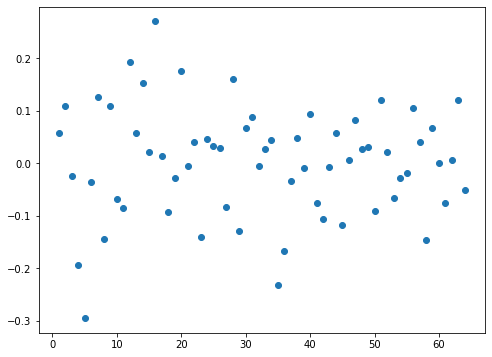

In [62]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Reconstruction','Original'],loc='upper left')

# Verify w/ Lv1...

In [ ]:
temp4 = np.zeros([1,Lv2_latent_dim])
temp4[0,:] = Lv2_latent[0,:]

Lv1_latent_decoded = Decoder(temp4)

In [ ]:
Lv2_latent.shape

In [ ]:
Lv1_latent_decoded.shape

In [ ]:
filename2='test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch_1)
Decoder_Lv1 = load_model(filename2)
Decoder_Lv1.summary()

In [ ]:
temp5 = np.zeros([1, Lv1_latent_dim])
temp6 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    temp5[0,:] = Lv1_latent_decoded[0,i,:]
    Lv1_decoded = Decoder_Lv1(temp5)
    temp6[i,:,:]=Lv1_decoded[0,:,:]
    


In [ ]:
Lv1_decoded.shape

In [ ]:
temp6.shape

In [ ]:
x_axis11 = np.linspace(1,num_time, num_time)

plt.scatter(x_axis11, temp6[:,0,0])

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [ ]:
Lv2_latent.shape

In [ ]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

In [ ]:
interp_Lv1_latent = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

In [ ]:
# Unscale

In [ ]:
interp_Lv1_latent = (interp_Lv1_latent*AT)+mean

In [ ]:
print(interp_Lv1_latent[0,0,0ccccccc], f[0,0,0])

In [ ]:
filename4 = 'interpolated_latentcode_batchnorm'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [ ]:
pause;